# Bam file Processing

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import anndata as ad 
from tqdm import tqdm as tqdm
import pysam

import scanpy as sc

## 1. Load and Process Bam file Output from cellranger

### Create and save a list of the barcodes (cells) of the 1k and 10k PBMCs

In [4]:

# import gzip

# # Define the input and output file names for 10k
# # input_file = '/data/dagyeman/cellranger/10k_PBMCs/new_results/outs/filtered_feature_bc_matrix/barcodes.tsv.gz'  # Update with the correct path if needed
# # output_file = '/data/dagyeman/cellranger/10k_PBMCs/new_results/outs/barcodes.txt'      # The output file name

# # Defind the input and output files for 1k
# input_file = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/filtered_feature_bc_matrix/barcodes.tsv.gz'  # Update with the correct path if needed
# output_file = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/barcodes.txt'      # The output file name

# # Open the gzipped TSV file and the output text file
# with gzip.open(input_file, 'rt') as f_in, open(output_file, 'w') as f_out:
#     for line in f_in:
#         f_out.write(line)

# print(f"Converted {input_file} to {output_file}")

Converted /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/filtered_feature_bc_matrix/barcodes.tsv.gz to /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/barcodes.txt


#### Load the Barcodes list from datasets saved above 

In [45]:

import numpy as np

# Specify the path to the .txt file for 10K PBMCs
# load_path = "/data/dagyeman/cellranger/10k_PBMCs/new_results/outs/barcodes.txt"  # Adjust this to the correct path

load_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/barcodes.txt"  # Adjust this to the correct path


# Load the barcodes from the .txt file
barcodes_loaded = np.loadtxt(load_path, dtype=str)

# Verify the barcodes are loaded
print(barcodes_loaded)

['AAACCCAAGGAGAGTA-1' 'AAACGCTTCAGCCCAG-1' 'AAAGAACAGACGACTG-1' ...
 'TTTGGTTAGTAACCTC-1' 'TTTGGTTGTAGAATAC-1' 'TTTGTTGCAATTAGGA-1']


#### Filters a BAM file to keep only reads whose cell barcodes match a given list, saving the result to a new BAM file.

In [1]:
import pysam
from tqdm import tqdm

# Path to the input BAM file for 1k
annotated_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results/outs/possorted_genome_bam.bam'

# Path to the input BAM file for 10k
# annotated_bam_path = '/data/dagyeman/cellranger/10k_PBMCs/new_results/outs/possorted_genome_bam.bam'

# Path to the output filtered BAM file for 1k
filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/filtered_1k_PBMCS_bam.bam'

# Path to the output filtered BAM file for 10k
# filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/filtered_10k_PBMCS_bam.bam'

# Load the list of barcodes of interest (bc_list)
bc_list = set(barcodes_loaded)  # Using a set for faster lookup

# Open the input BAM file for reading
with pysam.AlignmentFile(annotated_bam_path, "rb") as bam_file:
    # Open the output BAM file for writing, copying the header from the input BAM
    with pysam.AlignmentFile(filtered_bam_path, "wb", header=bam_file.header) as filtered_bam_file:
        # Iterate over each read in the BAM file
        for read in tqdm(bam_file):
            # Check if the read has both 'CB' (cell barcode) and 'GN' (gene name) tags
            if read.has_tag('CB') and read.has_tag('GN'):
                CB = read.get_tag('CB')
                # If the barcode is in the list of barcodes of interest, write the read to the new BAM file
                if CB in bc_list:
                    filtered_bam_file.write(read)

print(f"Filtered BAM file saved to {filtered_bam_path}")

NameError: name 'barcodes_loaded' is not defined

#### Extracts cell barcodes, genes, and UMIs from a filtered BAM file and saves them into a pandas DataFrame.

In [1]:
import pysam
import pandas as pd

# Path to the filtered BAM file
filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/filtered_1k_PBMCS_bam.bam' # filtered path for 1k dataset 
# filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/filtered_10k_PBMCS_bam.bam' # filtered bam path for 10k dataset

# List to store rows of data (barcode, gene, UMI)
data = []

# Open the filtered BAM file for reading
with pysam.AlignmentFile(filtered_bam_path, "rb") as bam_file:
    # Iterate over each read in the BAM file
    for read in bam_file:
        # Check if the read has 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
        if read.has_tag('CB') and read.has_tag('GN') and read.has_tag('UR'):
            # Extract the 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
            barcode = read.get_tag('CB')
            gene = read.get_tag('GN')
            umi = read.get_tag('UR')
            
            # Append the row to the data list
            data.append([barcode, gene, umi])

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data, columns=['barcode', 'gene', 'UMI'])

# Show the first few rows of the DataFrame
print(df.head())

              barcode        gene           UMI
0  GCTGCAGGTTGACGGA-1  AL627309.1  ATGAATTCGTTT
1  GCTGCAGGTTGACGGA-1  AL627309.1  ATGAATTCGTTT
2  CTGCCTATCTTGATTC-1  AL627309.1  CGGGTACTGCGC
3  GCGAGAAAGTTGTAGA-1  AL627309.1  TTGTAAAATACG
4  GGTCTGGTCAGACATC-1  AL627309.1  GGAAATCTGCGT


#### Generating dataframe containing information for all reads in the filtered bam file

In [2]:
# import pandas as pd


# # Loop through shortened UMI lengths from 1 to 12
# for k in range(1, 13):
#     # Shorten the 'UMI' to the first 'k' bases
#     df[f'UMI_{k}'] = df.UMI.str[:k]
    
#     # Group by 'barcode' and 'gene' and count the number of unique shortened UMIs for each combination
#     grouped_df = df.groupby(['barcode', 'gene'])[f'UMI_{k}'].nunique().reset_index()
    
#     # Rename the column to reflect that it's counting unique UMIs of length 'k'
#     grouped_df.rename(columns={f'UMI_{k}': f'unique_UMI_count_{k}'}, inplace=True)
    
#     # Optionally, you can store the resulting DataFrame for each 'k' or print the first few rows
#     print(f"Unique UMI counts for UMI length {k}:")
#     print(grouped_df.head())

# # Example: To merge results across different lengths (optional)
# # Merging results for all k values across lengths 1-12 into one DataFrame (if needed)
# final_df = df.groupby(['barcode', 'gene']).agg({f'UMI_{k}': 'nunique' for k in range(1, 13)}).reset_index()

# # Rename the columns accordingly to reflect the unique UMI counts for each length
# final_df.columns = ['barcode', 'gene'] + [f'unique_UMI_count_{k}' for k in range(1, 13)]

# # Show the first few rows of the final merged DataFrame
# print(final_df.head())

## Exploring the Uniformity of UMI 


In [2]:
import pandas as pd

# Filter out UMIs that contain 'N'
df = df[~df['UMI'].str.contains('N')]


In [3]:
# Loop through shortened UMI lengths from 1 to 12
for k in range(1, 13):
    # Shorten the 'UMI' to the first 'k' bases
    df[f'UMI_{k}'] = df.UMI.str[:k]
    
    # Group by 'barcode' and 'gene' and count the number of unique shortened UMIs for each combination
    grouped_df = df.groupby(['barcode', 'gene'])[f'UMI_{k}'].nunique().reset_index()
    
    # Rename the column to reflect that it's counting unique UMIs of length 'k'
    grouped_df.rename(columns={f'UMI_{k}': f'unique_UMI_count_{k}'}, inplace=True)
    
    # Optionally, you can store the resulting DataFrame for each 'k' or print the first few rows
    print(f"Unique UMI counts for UMI length {k}:")
    print(grouped_df.head())

# Example: To merge results across different lengths (optional)
# Merging results for all k values across lengths 1-12 into one DataFrame (if needed)
final_df = df.groupby(['barcode', 'gene']).agg({f'UMI_{k}': 'nunique' for k in range(1, 13)}).reset_index()

# Rename the columns accordingly to reflect the unique UMI counts for each length
final_df.columns = ['barcode', 'gene'] + [f'unique_UMI_count_{k}' for k in range(1, 13)]

# Show the first few rows of the final merged DataFrame
print(final_df.head())



Unique UMI counts for UMI length 1:
              barcode   gene  unique_UMI_count_1
0  AAACCCAAGGAGAGTA-1   AAK1                   3
1  AAACCCAAGGAGAGTA-1   AAMP                   2
2  AAACCCAAGGAGAGTA-1   AATK                   1
3  AAACCCAAGGAGAGTA-1   ABAT                   2
4  AAACCCAAGGAGAGTA-1  ABCB7                   2
Unique UMI counts for UMI length 2:
              barcode   gene  unique_UMI_count_2
0  AAACCCAAGGAGAGTA-1   AAK1                   4
1  AAACCCAAGGAGAGTA-1   AAMP                   2
2  AAACCCAAGGAGAGTA-1   AATK                   1
3  AAACCCAAGGAGAGTA-1   ABAT                   2
4  AAACCCAAGGAGAGTA-1  ABCB7                   2
Unique UMI counts for UMI length 3:
              barcode   gene  unique_UMI_count_3
0  AAACCCAAGGAGAGTA-1   AAK1                   4
1  AAACCCAAGGAGAGTA-1   AAMP                   2
2  AAACCCAAGGAGAGTA-1   AATK                   1
3  AAACCCAAGGAGAGTA-1   ABAT                   2
4  AAACCCAAGGAGAGTA-1  ABCB7                   2
Unique UMI

#### 2. Deduplicate to one UMI per cell–gene

In [4]:
k = 12
# create a k-base UMI column
df[f'UMI_{k}'] = df['UMI'].str[:k]

# now dedupe on that trimmed UMI, not the full one
unique_df_k = df.drop_duplicates(subset=['barcode','gene',f'UMI_{k}'])
print(f"Rows after deduplication (k={k}): {len(unique_df_k)}")


Rows after deduplication (k=12): 15568370


#### 3. For each gene, count “in how many cells does each UMI appear”

In [5]:
umi_cell_counts_k = (
    unique_df_k
    .groupby(['gene', f'UMI_{k}'])
    .size()
    .reset_index(name='cell_count')
)
umi_cell_counts_k.head()

,gene,UMI_12,cell_count
0,A1BG,AAACTCACTGAG,1
1,A1BG,AAACTCCTTAGG,1
2,A1BG,AAATACTAGGAT,1
3,A1BG,AAATGTCACCCA,1
4,A1BG,AAATTATCGTCC,1


In [9]:
# Compute total UMI–cell appearances per gene
gene_totals_k = (
    umi_cell_counts_k
    .groupby('gene')['cell_count']
    .sum()
)

# Sort descending and take top 30
top30_genes = gene_totals_k.sort_values(ascending=False).head(30).index.tolist()

print("Top 30 genes by total UMI cell appearances:")
for i, g in enumerate(top30_genes, 1):
    print(f"{i:2d}. {g} ({gene_totals_k[g]} total appearances)")


Top 30 genes by total UMI cell appearances:
 1. MALAT1 (379868 total appearances)
 2. MT-CO1 (203370 total appearances)
 3. MT-CO3 (185662 total appearances)
 4. MT-CO2 (147109 total appearances)
 5. MT-ATP6 (126052 total appearances)
 6. EEF1A1 (119826 total appearances)
 7. MT-ND3 (96831 total appearances)
 8. MT-ND4 (96204 total appearances)
 9. B2M (95052 total appearances)
10. IGKC (90963 total appearances)
11. RPL10 (82954 total appearances)
12. MT-CYB (81250 total appearances)
13. RPS27 (80994 total appearances)
14. TPT1 (79122 total appearances)
15. RPL41 (77902 total appearances)
16. TMSB4X (77569 total appearances)
17. RPL13 (76574 total appearances)
18. S100A9 (76181 total appearances)
19. RPS12 (71909 total appearances)
20. RPLP1 (71475 total appearances)
21. MT-ND1 (68004 total appearances)
22. ACTB (63064 total appearances)
23. RPL39 (57311 total appearances)
24. RPL34 (56574 total appearances)
25. FTL (54463 total appearances)
26. RPS18 (54287 total appearances)
27. RPS3

#### 4. Visualize the UMI‐cell_count distribution for a given gene

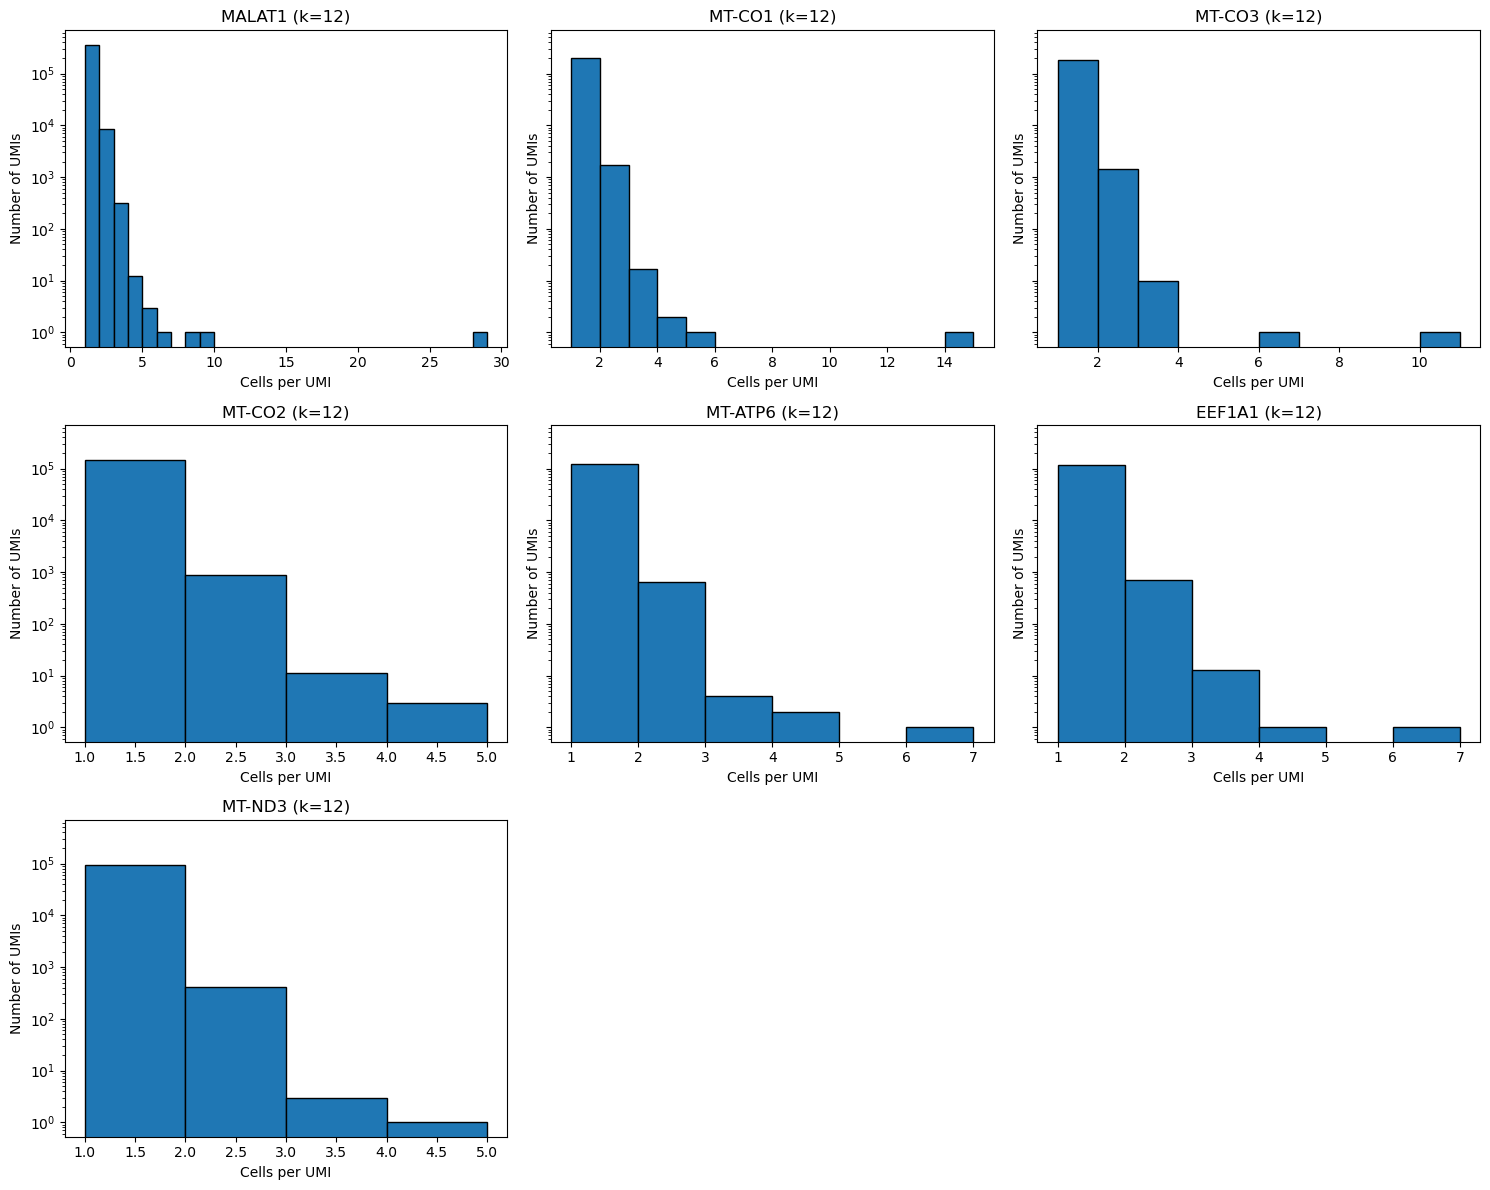

In [10]:
## Plotting “Cells per UMI” Distributions for Multiple Genes

import matplotlib.pyplot as plt
import numpy as np

# List of genes to plot
top_genes = [
    'MALAT1',   # 379868 total appearances
    'MT-CO1',   # 203370 total appearances
    'MT-CO3',   # 185662 total appearances
    'MT-CO2',   # 147109 total appearances
    'MT-ATP6',  # 126052 total appearances
    'EEF1A1',   # 119826 total appearances
    'MT-ND3'    # 96831 total appearances
]

# Number of columns for subplot grid
ncols = 3
nrows = int(np.ceil(len(top_genes) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)

for ax, gene in zip(axes.flatten(), top_genes):
    counts = umi_cell_counts_k.loc[umi_cell_counts_k['gene'] == gene, 'cell_count']
    ax.hist(
        counts,
        bins=np.arange(1, counts.max() + 2),
        edgecolor='k'
    )
    ax.set_title(f"{gene} (k={k})")
    ax.set_xlabel("Cells per UMI")
    ax.set_ylabel("Number of UMIs")
    ax.set_yscale('log')

# Turn off any unused subplots
for empty_ax in axes.flatten()[len(top_genes):]:
    empty_ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# For each gene, print its top 10 UMIs by cell_count
for gene in top_genes:
    top_umis = (
        umi_cell_counts_k[umi_cell_counts_k['gene'] == gene]
        .nlargest(10, 'cell_count')      # sort descending by cell_count
        .reset_index(drop=True)
    )
    print(f"\nGene {gene} – Top 10 UMIs (k={k}):")
    print(top_umis[['UMI_' + str(k), 'cell_count']])



Gene MALAT1 – Top 10 UMIs (k=12):
         UMI_12  cell_count
0  TTTTTTTTTTTT          28
1  CTTTTTTTTTTT           9
2  GTTTTTTTTTTT           8
3  TCTTTTTTTTTT           6
4  CCCCTTTTTTGT           5
5  TATCTTTTTGTT           5
6  TTTTTTTTTTTC           5
7  ACTATTTTCTTT           4
8  AGTTCCTTCCAT           4
9  AGTTTTTTCTTT           4

Gene MT-CO1 – Top 10 UMIs (k=12):
         UMI_12  cell_count
0  TTTTTTTTTTTT          14
1  GTTTTTTTTTTT           5
2  ACTGTGCACGGT           4
3  TTTTAGCTTTTT           4
4  AATACGCTTAGT           3
5  ACGAGTTTTGGT           3
6  ATATTTTTTTTG           3
7  CAATTTTCGTTT           3
8  CTACTCCTGTTT           3
9  CTGTTGTGTCTC           3

Gene MT-CO3 – Top 10 UMIs (k=12):
         UMI_12  cell_count
0  TTTTTTTTTTTT          10
1  GTTTTTTTTTTT           6
2  AATTAGTTAGTA           3
3  AATTTTTTTTTT           3
4  AGATTTTTTTTT           3
5  ATTTGTTTTTTT           3
6  ATTTTTTTTTTT           3
7  GCTCTTTGTTTG           3
8  GGTCTACCTATT           3

In [12]:
# 1) Collect all top-10 UMIs into one DataFrame
records = []
for gene in top_genes:
    top_umis = (
        umi_cell_counts_k[umi_cell_counts_k['gene'] == gene]
        .nlargest(10, 'cell_count')
    )
    for _, row in top_umis.iterrows():
        records.append({
            'gene': gene,
            'UMI': row[f'UMI_{k}'],
            'cell_count': row['cell_count']
        })

top10_df = pd.DataFrame(records)

# 2) Find UMIs appearing in more than one gene’s top-10
shared = (
    top10_df
    .groupby('UMI')
    .agg({
        'gene': lambda gs: list(gs),
        'cell_count': lambda cs: list(cs)
    })
    .reset_index()
)

shared = shared[shared['gene'].map(len) > 1]

# 3) Print shared UMIs with their genes and counts
if shared.empty:
    print("No UMIs are shared among the top-10 lists of multiple genes.")
else:
    print("Shared UMIs across top-10 lists:")
    for _, row in shared.iterrows():
        umi_seq = row['UMI']
        pairs = ", ".join(f"{g}({c})" for g, c in zip(row['gene'], row['cell_count']))
        print(f"UMI {umi_seq!r} → {pairs}")


Shared UMIs across top-10 lists:
UMI 'ATTTTTTTTTTT' → MT-CO3(3), MT-CO2(3)
UMI 'CTTTTTTTTTTT' → MALAT1(9), EEF1A1(4)
UMI 'GTTTTTTTTTTT' → MALAT1(8), MT-CO1(5), MT-CO3(6), MT-CO2(3), MT-ATP6(4)
UMI 'TCTTTTTTTTTT' → MALAT1(6), MT-CO2(4)
UMI 'TTTTTTTTTTTT' → MALAT1(28), MT-CO1(14), MT-CO3(10), MT-CO2(4), MT-ATP6(6), EEF1A1(6), MT-ND3(3)


## More analysis

In [23]:
# from itertools import combinations

# def hamming(a, b):
#     return sum(x!=y for x, y in zip(a, b))

# #pick pairs with high UMI12 but low UMI5 collapse:
# candidates = final_df[
#     (final_df['unique_UMI_count_12'] < 20) &
#     (final_df['unique_UMI_count_5'] <2)
# ].head(10)

# for _, r in candidates.iterrows():
#     cell, gene = r['barcode'], r['gene']
#     umis = unique_df_k[
#         (unique_df_k['barcode']==cell) &
#         (unique_df_k['gene']==gene)
#     ]['UMI_12'].unique().tolist()
#     print(f"\n{cell}–{gene}: {len(umis)} UMIs → sample: {umis[:10]}")
#     # eyeball these for single-base mismatches



AAACCCAAGGAGAGTA-1–AATK: 1 UMIs → sample: ['ATCTTTCGGGTA']

AAACCCAAGGAGAGTA-1–ABHD13: 1 UMIs → sample: ['GTTGGTGTGCAC']

AAACCCAAGGAGAGTA-1–ABHD15-AS1: 1 UMIs → sample: ['TAAGTCGTGCAC']

AAACCCAAGGAGAGTA-1–ABHD17A: 1 UMIs → sample: ['AGAATTTATTAT']

AAACCCAAGGAGAGTA-1–ABHD6: 1 UMIs → sample: ['GTAACCTAGTCT']

AAACCCAAGGAGAGTA-1–ABL1: 1 UMIs → sample: ['AAAGAAACAGGC']

AAACCCAAGGAGAGTA-1–AC002451.1: 1 UMIs → sample: ['AAAAATCCTACG']

AAACCCAAGGAGAGTA-1–AC002464.1: 1 UMIs → sample: ['GGCTAAGTTGTG']

AAACCCAAGGAGAGTA-1–AC004687.1: 1 UMIs → sample: ['CGCCAGAATTAT']

AAACCCAAGGAGAGTA-1–AC004921.1: 1 UMIs → sample: ['CTCGCCGTTGAC']


### Checking for sequencing errors

##### 1. Define lengths: Set k_small and k_full = 12
##### 2. Filter pairs: Select all (cell, gene) rows from final_df where the 5 base UMI count is exactly 1 but the 12-base UMI count is greater than 1 
##### 3. Iterate candidates: For each of those filtered cell-gene pairs: 

In [27]:

k_small, k_full = 5, 12
cands = final_df[
    (final_df[f'unique_UMI_count_{k_small}'] == 1) &
    (final_df[f'unique_UMI_count_{k_full}']  > 4)
]

for _, row in cands.iterrows():
    cell, gene = row['barcode'], row['gene']
    umis12 = unique_df_k[
        (unique_df_k['barcode'] == cell) &
        (unique_df_k['gene']    == gene)
    ]['UMI_12'].unique().tolist()
    
    print(f"\n{cell}–{gene}: k=5 count=1, k=12 count={len(umis12)} UMIs → {umis12}")



AAGACAACAGATCACT-1–BRWD1: k=5 count=1, k=12 count=5 UMIs → ['CACAGTCGCTAG', 'CACAGTCGCTAT', 'CACAGTCGCGAG', 'CACAGTCGCGAT', 'CACAGTCGCTCT']

AAGGTAAAGGAAGTAG-1–PAPSS1: k=5 count=1, k=12 count=5 UMIs → ['AGGCGTGTAGTT', 'AGGCGTTTATTT', 'AGGCGTTTTTTT', 'AGGCGTGTATTT', 'AGGCGTTTAGTT']

AATGGAATCTGATGGT-1–ANGEL1: k=5 count=1, k=12 count=5 UMIs → ['CCGGGTCGTTGT', 'CCGGGTCGTGCT', 'CCGGGTCGTTCT', 'CCGGGTCGTTCG', 'CCGGGTCGTGCG']

ACCTACCCAACGGTAG-1–CACYBP: k=5 count=1, k=12 count=5 UMIs → ['GGTCGCTTTGTG', 'GGTCGCGTTGAG', 'GGTCGCGTTGTG', 'GGTCGCTTTGAT', 'GGTCGCTTTGAG']

AGTAACCCAAGCTCTA-1–SERGEF: k=5 count=1, k=12 count=5 UMIs → ['GAGTCGGTTTCG', 'GAGTCGGTTTCC', 'GAGTCGGGTTCG', 'GAGTCGGGGACC', 'GAGTCGGGTACG']

ATAGGCTGTGTTACAC-1–POLA2: k=5 count=1, k=12 count=6 UMIs → ['AGTCGCTTGGAG', 'AGTCGCTTGGTT', 'AGTCGCGTGGCG', 'AGTCGCTTTGAG', 'AGTCGCTTGGTG', 'AGTCGCTTTGTT']

ATGACCACAATATCCG-1–ADIPOR2: k=5 count=1, k=12 count=5 UMIs → ['GTCGTGTTTTTT', 'GTCGTTTTTTTT', 'GTCGTGTTGTTT', 'GTCGTTTTGTTT', 'GTCGTG

In [ ]:

k_small, k_full = 5, 12
cands = final_df[
    (final_df[f'unique_UMI_count_{k_small}'] == 1) &
    (final_df[f'unique_UMI_count_{k_full}']  > 700)
]

for _, row in cands.iterrows():
    cell, gene = row['barcode'], row['gene']
    umis12 = unique_df_k[
        (unique_df_k['barcode'] == cell) &
        (unique_df_k['gene']    == gene)
    ]['UMI_12'].unique().tolist()
    
    print(f"\n{cell}–{gene}: k=5 count=1, k=12 count={len(umis12)} UMIs → {umis12}")


In [ ]:
import random
from itertools import combinations
from collections import Counter

def fraction_hd1(umi_list):
    """Compute fraction of pairs with Hamming distance = 1."""
    total = 0
    hd1 = 0
    for a, b in combinations(umi_list, 2):
        total += 1
        if hamming(a, b) == 1:
            hd1 += 1
    return hd1 / total if total else 0

# Build a lookup of empirical UMI12 frequencies
umi_freq = unique_df_k['UMI_12'].value_counts(normalize=True).to_dict()
umis, probs = zip(*umi_freq.items())

# For each (cell, gene) with, say, ≥ n UMIs, compare to random draw
results = []
for _, row in final_df.iterrows():
    cell, gene = row['barcode'], row['gene']
    n = int(row['unique_UMI_count_12'])
    if n < 100:  # skip small samples
        continue

    # real UMIs
    real_umis = unique_df_k.loc[
        (unique_df_k['barcode']==cell) &
        (unique_df_k['gene']==gene),
        'UMI_12'
    ].unique().tolist()
    real_frac = fraction_hd1(real_umis)

    # synthetic draws
    synth = random.choices(umis, probs, k=n)
    synth_frac = fraction_hd1(synth)

    results.append({
        'cell': cell,
        'gene': gene,
        'n_umis': n,
        'real_hd1_frac': real_frac,
        'synth_hd1_frac': synth_frac
    })

hd1_df = pd.DataFrame(results)


In [ ]:
# how many (cell,gene) points have real_frac > synth_frac?
print((hd1_df['real_hd1_frac'] > hd1_df['synth_hd1_frac']).mean())

# or plot:
hd1_df.plot.scatter('n_umis', 'real_hd1_frac', alpha=0.3, label='real')
hd1_df.plot.scatter('n_umis', 'synth_hd1_frac', alpha=0.3, label='synth')
plt.ylabel("Fraction of UMI pairs at Hamming=1")
plt.legend()


### COnusion matrix

In [6]:
import pandas as pd

k_small, k_full = 5, 12

# Create a DataFrame with only the necessary columns
counts_df = final_df[[
    'barcode', 'gene', 
    f'unique_UMI_count_{k_small}', 
    f'unique_UMI_count_{k_full}'
]].copy()

# Rename columns for easier use
counts_df.columns = ['barcode', 'gene', 'count_k_small', 'count_k_full']

# Filter to include only counts from 1 to 10 (can adjust range if needed)
counts_df = counts_df[
    (counts_df['count_k_small'] <= 10) & (counts_df['count_k_full'] <= 10)
]

# Create the confusion matrix (cross-tabulation)
conf_matrix = pd.crosstab(
    counts_df['count_k_small'], 
    counts_df['count_k_full']
)

# Reindex to ensure all rows/columns 1–10 are present, even if empty
conf_matrix = conf_matrix.reindex(index=range(1,11), columns=range(1,11), fill_value=0)

# Display
conf_matrix


count_k_full,1,2,3,4,5,6,7,8,9,10
count_k_small,,,,,,,,,,
1,2202437,102812,3174,114,23,4,0,0,0,1
2,0,758826,72182,4091,220,6,7,0,0,0
3,0,0,337408,48415,3880,263,21,2,3,0
4,0,0,0,173307,33368,3618,295,30,2,0
5,0,0,0,0,98265,23858,3227,316,27,5
6,0,0,0,0,0,59618,17647,2908,368,35
7,0,0,0,0,0,0,38469,13585,2601,359
8,0,0,0,0,0,0,0,26143,10478,2343
9,0,0,0,0,0,0,0,0,18259,8437


### Hamming Distance

In [7]:
# import random
# from itertools import combinations

# def hamming(a, b):
#     return sum(x != y for x, y in zip(a, b))

# def fraction_hd1(umi_list):
#     """Compute fraction of UMI pairs with Hamming distance = 1."""
#     total = 0
#     hd1 = 0
#     for a, b in combinations(umi_list, 2):
#         total += 1
#         if hamming(a, b) == 1:
#             hd1 += 1
#     return hd1 / total if total else 0

# # Step 1: Select 100 random (cell, gene) pairs with UMI_12 count between 2 and 10
# k_full = 12
# lower, upper = 3, 10

# eligible = final_df[
#     (final_df[f'unique_UMI_count_{k_full}'] >= lower) &
#     (final_df[f'unique_UMI_count_{k_full}'] <= upper)
# ]

# cands = eligible.sample(n=min(100, len(eligible)), random_state=42)

# num_available = len(eligible)
# print(f"Number of cell-gene pairs with UMI_{k_full} count between {lower} and {upper}: {num_available}")

Number of cell-gene pairs with UMI_12 count between 3 and 10: 1020785


['barcode', 'gene', 'unique_UMI_count_1', 'unique_UMI_count_2', 'unique_UMI_count_3', 'unique_UMI_count_4', 'unique_UMI_count_5', 'unique_UMI_count_6', 'unique_UMI_count_7', 'unique_UMI_count_8', 'unique_UMI_count_9', 'unique_UMI_count_10', 'unique_UMI_count_11', 'unique_UMI_count_12']


194
Computed HD ≤ 2 fraction from 194 sampled UMIs: 0.01650553


### Null sample

In [21]:
import random
from itertools import combinations
import numpy as np

def hamming(a, b):
    return sum(x != y for x, y in zip(a, b))

def fraction_hd_leq2(umi_list):
    total = 0
    close_pairs = 0
    for a, b in combinations(umi_list, 2):
        total += 1
        dist = hamming(a, b)
        if dist <= 2:
            close_pairs += 1
    return close_pairs / total if total else 0

# Extract all unique UMI_12s from the dataset
all_umis = unique_df_k['UMI_12'].unique().tolist()

# Repeat sampling and computation 100 times
n_iterations = 100
hd_leq2_fractions = []

for _ in range(n_iterations):
    sampled_umis = random.sample(all_umis, 500)
    frac = fraction_hd_leq2(sampled_umis)
    hd_leq2_fractions.append(frac)

# Convert to NumPy array if needed
hd_leq2_fractions = np.array(hd_leq2_fractions)



## Statistics

In [22]:
import random
from itertools import combinations
import numpy as np

def hamming(a, b):
    return sum(x != y for x, y in zip(a, b))

def fraction_hd_leq2(umi_list):
    total = 0
    close_pairs = 0
    for a, b in combinations(umi_list, 2):
        total += 1
        dist = hamming(a, b)
        if dist <= 2:
            close_pairs += 1
    return close_pairs / total if total else 0

# Set UMI lengths
k_small, k_full = 5, 12
num = 500

# Step 1: Filter for cell-gene pairs with count_k_full < 10 and |count_k_full - count_k_small| ≥ 2
eligible = final_df[
    (final_df[f'unique_UMI_count_{k_full}'] <= 10) &
    (abs(final_df[f'unique_UMI_count_{k_full}'] - final_df[f'unique_UMI_count_{k_small}']) >= 5)
]

# Step 2: Filter UMIs in unique_df_k to only those from eligible barcode-gene pairs
filtered_umis_df = unique_df_k.merge(
    eligible[['barcode', 'gene']],
    on=['barcode', 'gene'],
    how='inner'
)

# Step 3: Extract all UMIs and attempt to sample 500 (or fewer if not enough)
all_umis = filtered_umis_df['UMI_12'].tolist()
sampled_umis = random.sample(all_umis, num) if len(all_umis) >= num else all_umis

print(len(sampled_umis))

# Step 4: Compute the fraction of UMI pairs with Hamming distance ≤ 2
hd_fraction = fraction_hd_leq2(sampled_umis)
print(f"Computed HD ≤ 2 fraction from {len(sampled_umis)} sampled UMIs: {hd_fraction:.8f}")


194
Computed HD ≤ 2 fraction from 194 sampled UMIs: 0.01650553


In [26]:
p_value_10 = (sum(hd_fraction <= hd_leq2_fractions) + 1) / (n_iterations + 1)
p_value_10 

np.float64(0.009900990099009901)

#### Creating adata matrices from the reads dataframe above

In [51]:
import pandas as pd
import anndata as ad

# Assuming final_df is already defined
# Initialize a dictionary to store the AnnData objects for each UMI length
adata_dict = {}

# Loop through UMI lengths from 1 to 12
for k in range(1, 13):
    # Select the columns for the current UMI length
    adata_matrix = final_df[['barcode', 'gene', f'unique_UMI_count_{k}']]

    # Pivot the DataFrame to create a matrix with barcodes as rows and genes as columns
    matrix_df = adata_matrix.pivot(index='barcode', columns='gene', values=f'unique_UMI_count_{k}').fillna(0)

    # Convert the DataFrame into an AnnData object, setting barcodes as observation names (obs_names)
    adata = ad.AnnData(X=matrix_df.values)

    # Set the observation names (obs_names) directly to the barcodes
    adata.obs_names = matrix_df.index

    # Set the variable names (var_names) to the actual gene names
    adata.var_names = matrix_df.columns

    # Add the AnnData object to the dictionary with UMI length as the key
    adata_dict[k] = adata

# Example: Print the structure of the AnnData object for UMI length 1
print(adata_dict[1])  # Accessing the AnnData object for UMI length 1.

AnnData object with n_obs × n_vars = 1232 × 28227


#### Identifying the cells withe most counts

In [49]:
# Set how many top cells you want
top_barcodes = 1000  # Change this value as needed

# Get the adata matrix for UMI length 12
adata12 = adata_dict[12]

# Sum total counts for each cell
total_counts = adata12.X.sum(axis=1)

# If X is sparse, convert to dense array
if not isinstance(total_counts, np.ndarray):
    total_counts = np.array(total_counts).flatten()

# Get indices of the top N cells
top_indices = np.argsort(total_counts)[::-1][:top_barcodes]

# Get barcodes and their corresponding total counts
top_barcodes_list = adata12.obs_names[top_indices]
top_counts = total_counts[top_indices]

# Print barcode and count side by side
for barcode, count in zip(top_barcodes_list, top_counts):
    print(f"{barcode}: {count:.0f}")

# Save the list of barcodes to a .txt file
with open("bam_file_analysis/1k_PBMCs/ur_objects/top_barcodes.txt", "w") as f:
    for barcode in top_barcodes_list:
        f.write(f"{barcode}\n")


CGAGAAGTCAAGTTGC-1: 81728
GATCACACACCCTGTT-1: 76516
CTACAGACAACAAAGT-1: 62465
GGTTGTATCGAAGGAC-1: 52593
TCGACCTCAAGTAGTA-1: 47036
TATCTTGTCCATCTCG-1: 45555
CAGGTATGTCAGTCTA-1: 39440
AAGACAACAGATCACT-1: 38973
CCTCCAAAGGCCCGTT-1: 38770
TTGTTCACACTTGTGA-1: 38322
TGTTCATAGCTGCCTG-1: 37878
CCGATGGGTTCTCGCT-1: 37220
CACTTCGTCACCTACC-1: 36546
CGAGAAGTCCAATGCA-1: 35839
TATCGCCTCTCCCAAC-1: 35569
TGTTTGTGTGGAAATT-1: 34009
TCCTCTTAGCCAAGGT-1: 33576
TCCTTCTCAACTCGTA-1: 33108
CACTGAATCCTGATAG-1: 32983
ATGGGAGCACTCCGGA-1: 32872
GCTTCACCAACACGAG-1: 32677
TGTCCACTCGCTTACC-1: 32139
TCTCCGAAGTCAATCC-1: 32053
CAAGCTAGTGGCTGCT-1: 31781
GAAGCCCCAGGAACCA-1: 31734
TCACACCCACCAGCCA-1: 31714
ACCTGTCTCTCAACGA-1: 31063
GTGTGGCAGGTACTGG-1: 30713
ATCACTTGTGGCTGCT-1: 30694
CGTTAGATCATTATCC-1: 30605
TCAGCAAGTATGACAA-1: 30604
GGTGTTAGTGGATTTC-1: 30603
GTAGTACTCTGTGTGA-1: 30117
AATGACCGTGTCATCA-1: 29838
CTCCCTCCACCGGAAA-1: 29607
GTTAGTGCACCTCTAC-1: 29588
CCTAAGAAGACTCTAC-1: 29476
AACGGGAGTCGCTCGA-1: 29249
CCGAACGAGGAA

In [8]:
!pwd

/data/dagyeman/cellranger


#### Saving adata matrices

In [52]:
import os
# Directory to save AnnData matrices

# For 1k PBMCs
# save_directory = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices'
save_directory = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices'

# For 10k PBMCs
# save_directory = '/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Save each AnnData object from the dictionary
for k, adata in adata_dict.items():
    adata_path = os.path.join(save_directory, f'adata_{k}.h5ad')
    adata.write_h5ad(adata_path)

# Example: Print a confirmation message after saving
print(f"Saved AnnData matrices for UMI lengths 1 to 12 in {save_directory}.")

Saved AnnData matrices for UMI lengths 1 to 12 in /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices.


## 2. Modeling

##### Load the newly created adata matrices into adata_dict dictionary

In [53]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
print(adata_dict[6])

AnnData object with n_obs × n_vars = 1232 × 28227


#### Modeling to confirm adata objects were created properly (Naive Approach)

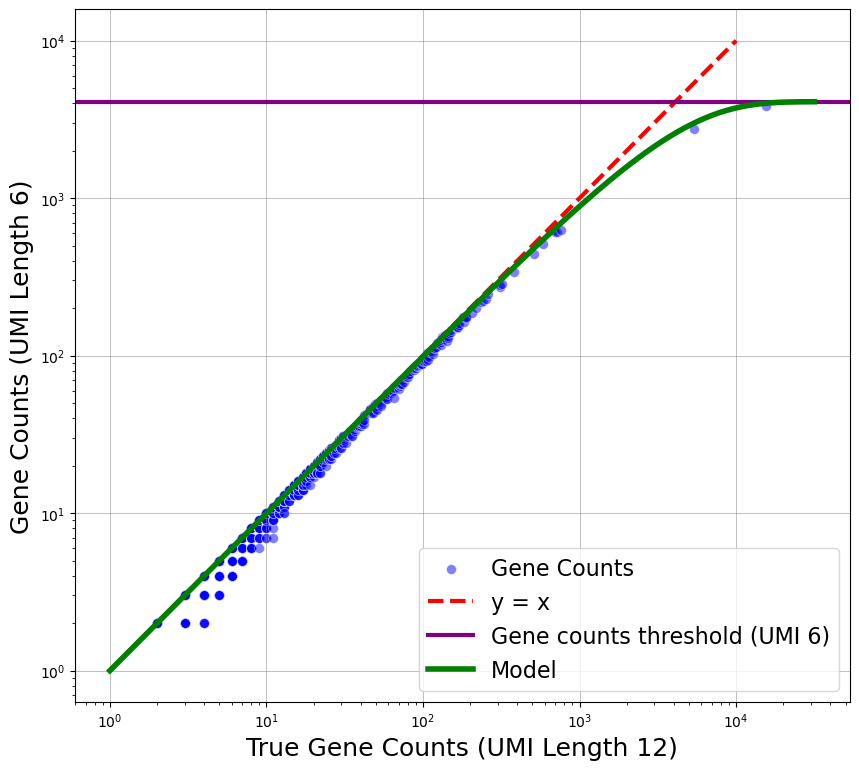

In [54]:
# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    results = []
    for n in n_vals:
        result = 4**j * (1 - (1 - 1 / 4**j)**n)
        results.append(result) 
    return np.array(results)



# Define parameters
 # Example values for n (or x)


i = 12
j = 6
# # NOTE: Load the top_barcodes array from the text file
# top_barcodes = np.loadtxt(f'{resolution}/top_barcodes.txt', dtype=str)



barcode = "CTACAGACAACAAAGT-1" #1k
# barcode = "CAGATTGCAGAGTGAC-1"

# Find the index of the barcode in each AnnData object
index1 = np.where(adata_dict[i].obs_names == barcode)[0][0]
index2 = np.where(adata_dict[j].obs_names == barcode)[0][0]

# Extract the gene counts for the barcode from both AnnData objects
gene_counts1 = adata_dict[i].X[index1].flatten()  # Gene counts for UMI length i (e.g., 12)
gene_counts2 = adata_dict[j].X[index2].flatten()  # Gene counts for UMI length j (e.g., 6)

# Create a boolean mask for gene_counts1 that are greater than or equal to 1
mask = gene_counts1 >= 1 

# Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
gene_counts1 = gene_counts1[mask]
gene_counts2 = gene_counts2[mask]

# Sort the gene counts based on gene_counts1
sorted_indices = np.argsort(gene_counts1)
sorted_gene_counts1 = gene_counts1[sorted_indices]
sorted_gene_counts2 = gene_counts2[sorted_indices]

# Add 1 to both sorted_gene_counts1 and sorted_gene_counts2 to handle log scale properly
sorted_gene_counts1 = sorted_gene_counts1 + 1
sorted_gene_counts2 = sorted_gene_counts2 + 1

# Create the scatter plot
plt.figure(figsize=(10, 9))
plt.scatter(sorted_gene_counts1, sorted_gene_counts2, alpha=0.5, c='blue', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

# Adding the identity line
max_val = max(sorted_gene_counts1.max(), sorted_gene_counts2.max())
# plt.plot([1, max_val], [1, max_val], 'r--', linewidth=3, label='y = x') #1k
plt.plot([1, 10000], [1, 10000], 'r--', linewidth=3, label='y = x') #10k


n_values = np.logspace(0, 4.5, 200)

# Use actual gene counts as n values
f_n_4j = f(n_values, j)

# Plot the y = 4^j asymptotic line
y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='purple', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

# Plot the function values as a line
plt.plot(n_values, f_n_4j, 'g-', linewidth=4, label="Model")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(f'True Gene Counts (UMI Length {i})', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
# plt.title(f"1k_PBMC: Gene Counts for {barcode}")
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16)

plt.show()

#### Saving the naive modeling plots

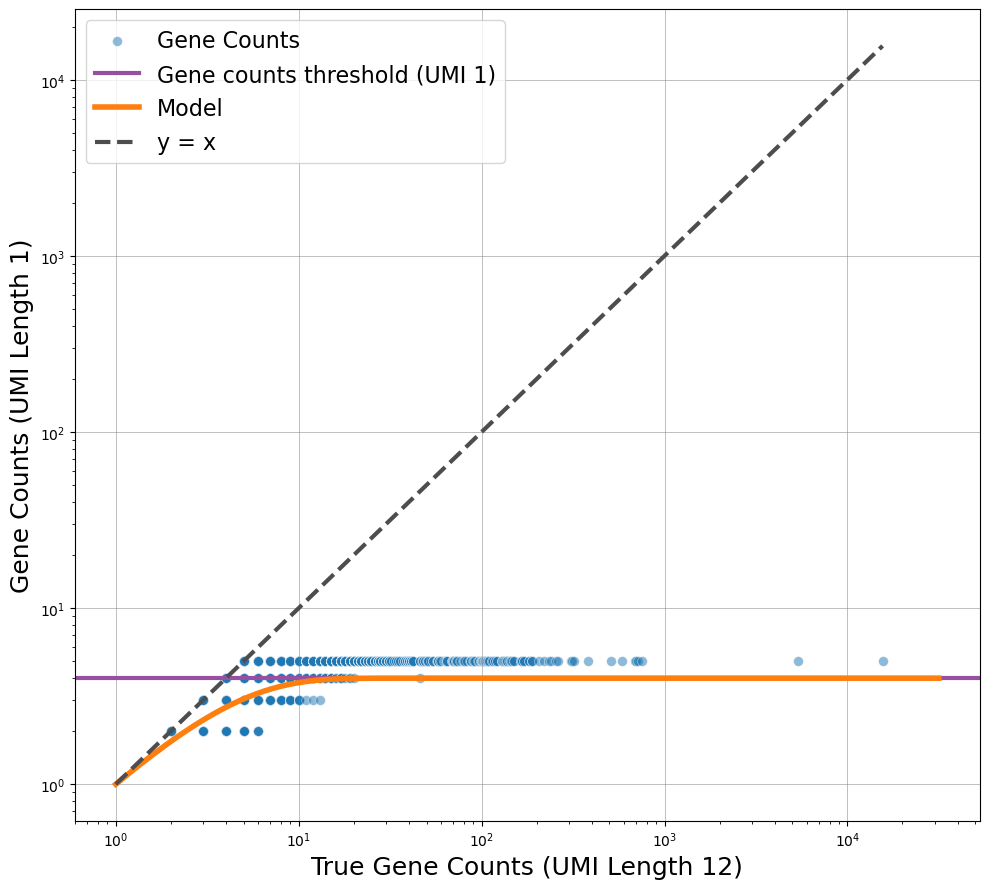

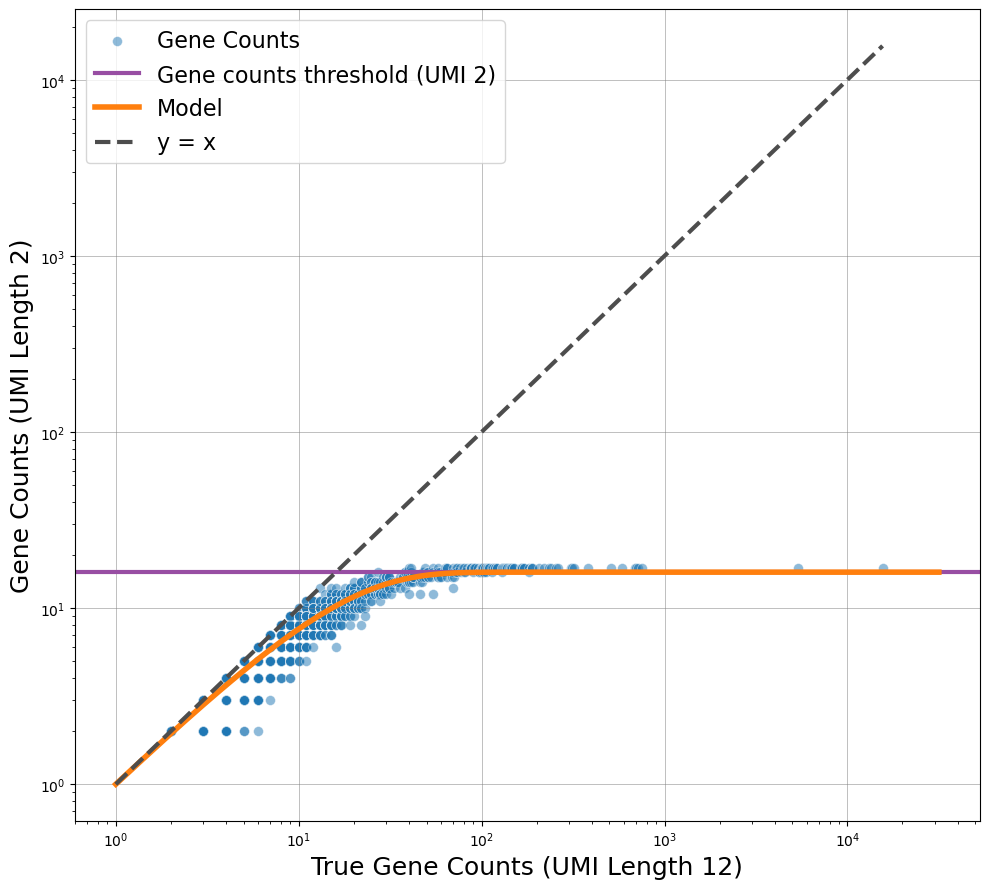

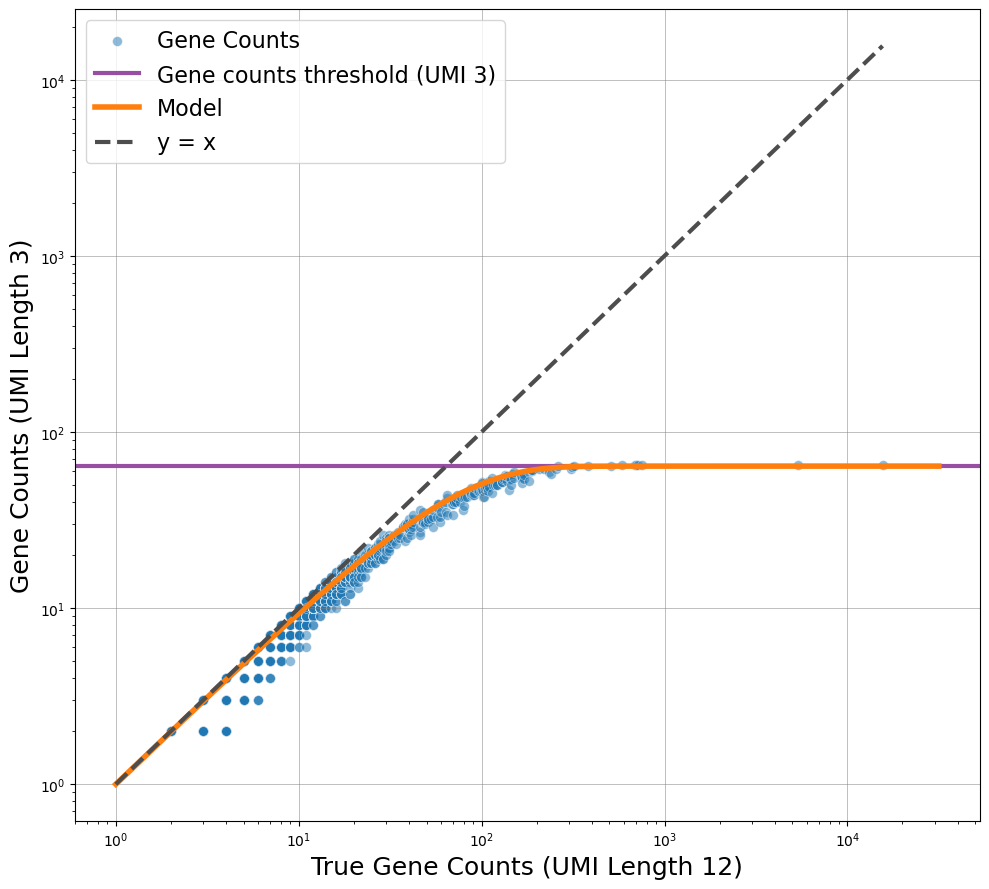

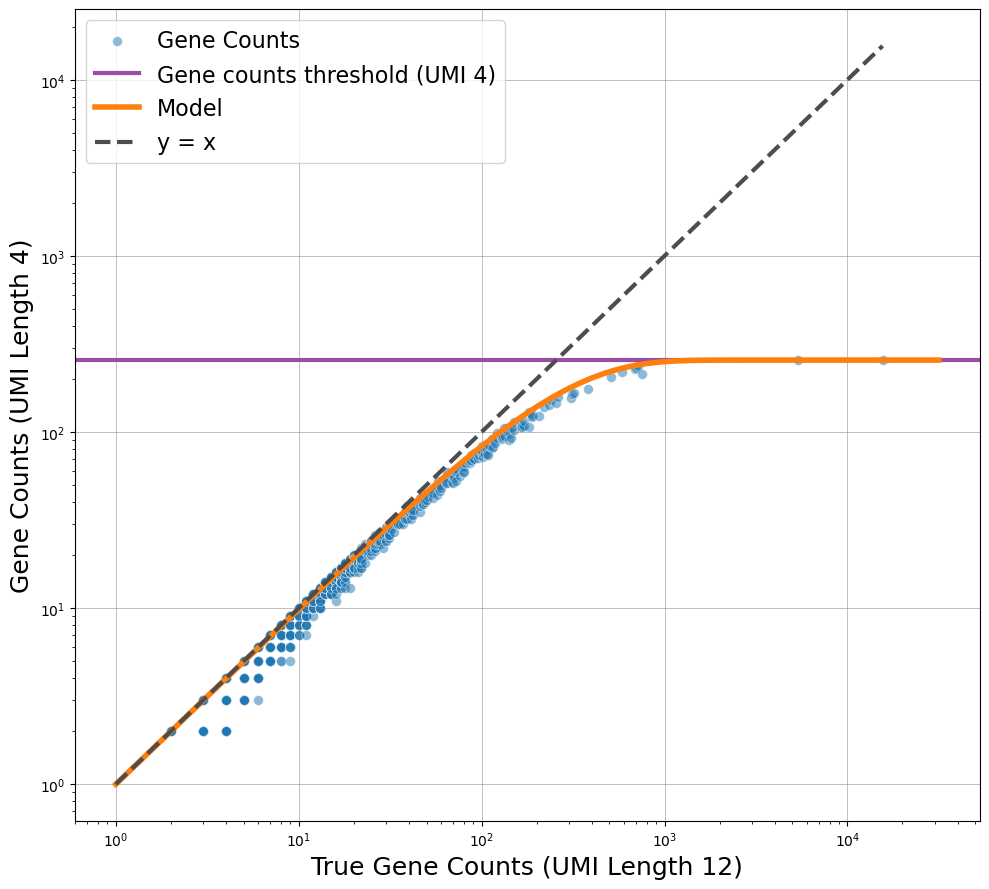

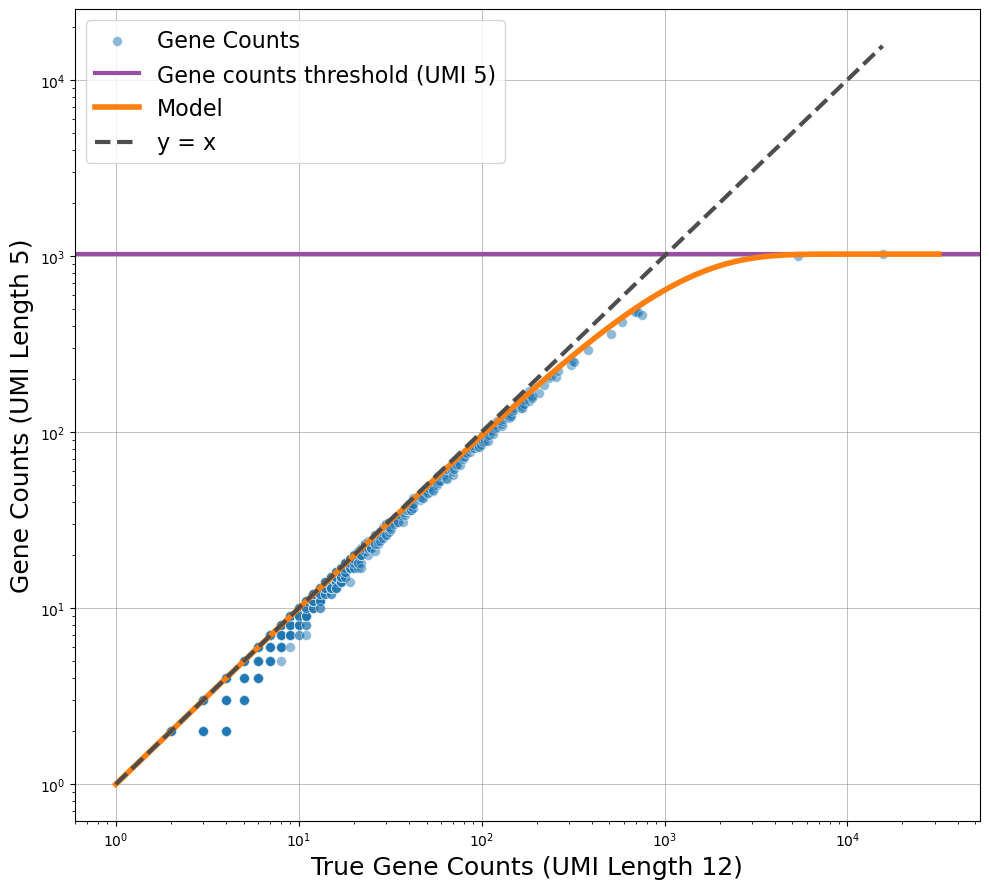

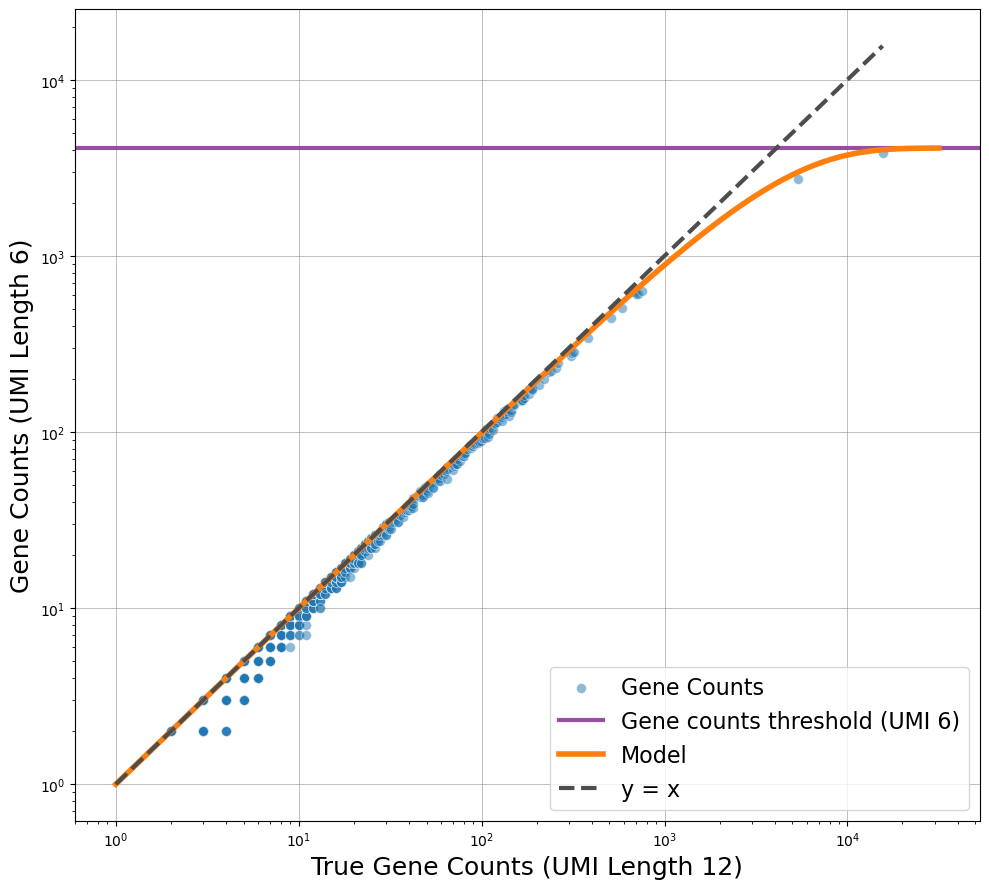

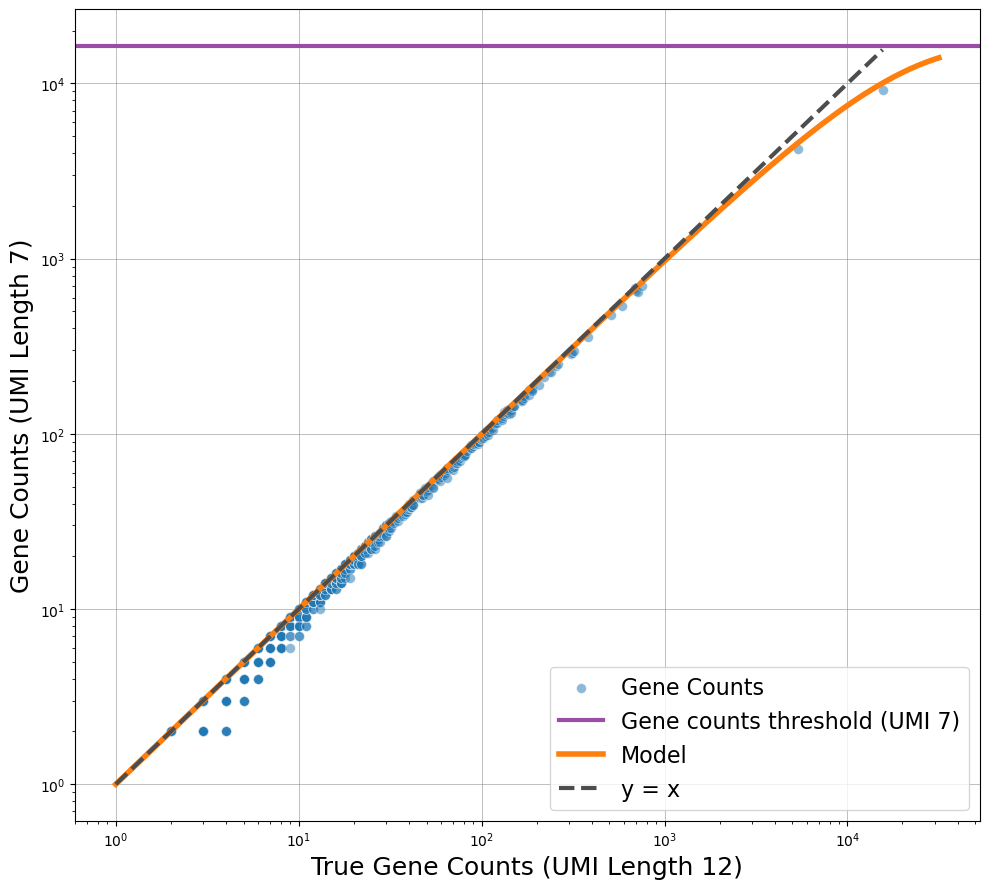

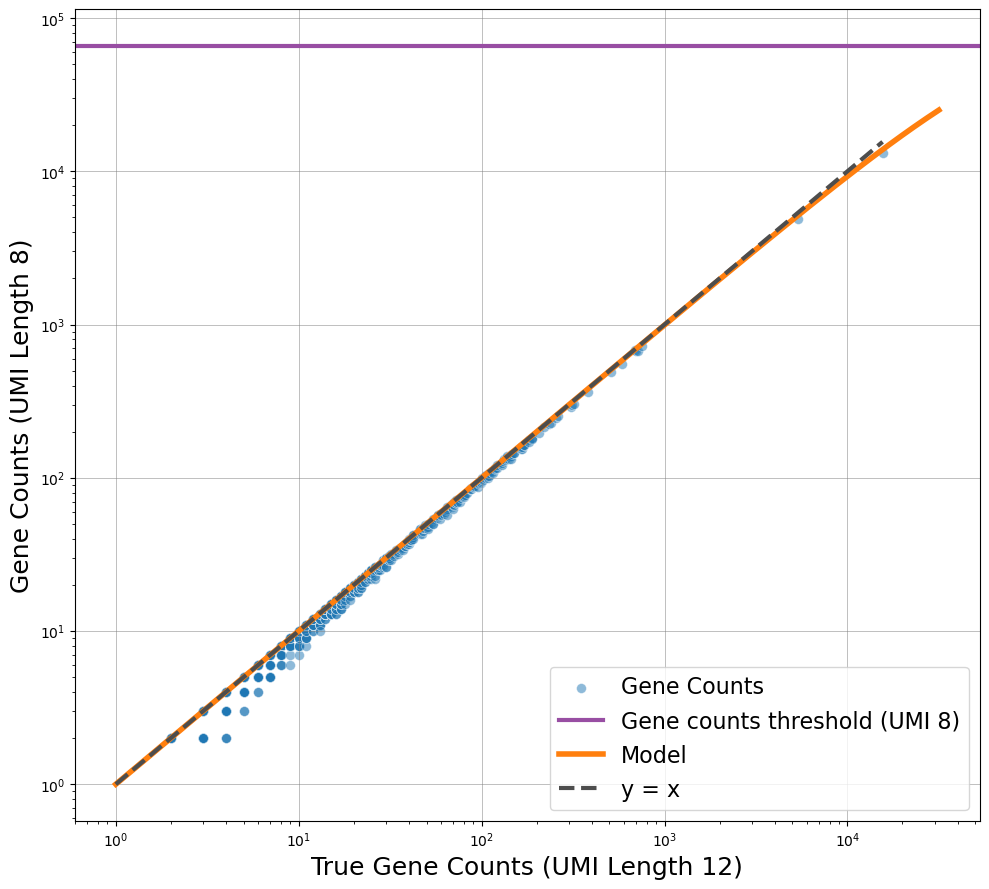

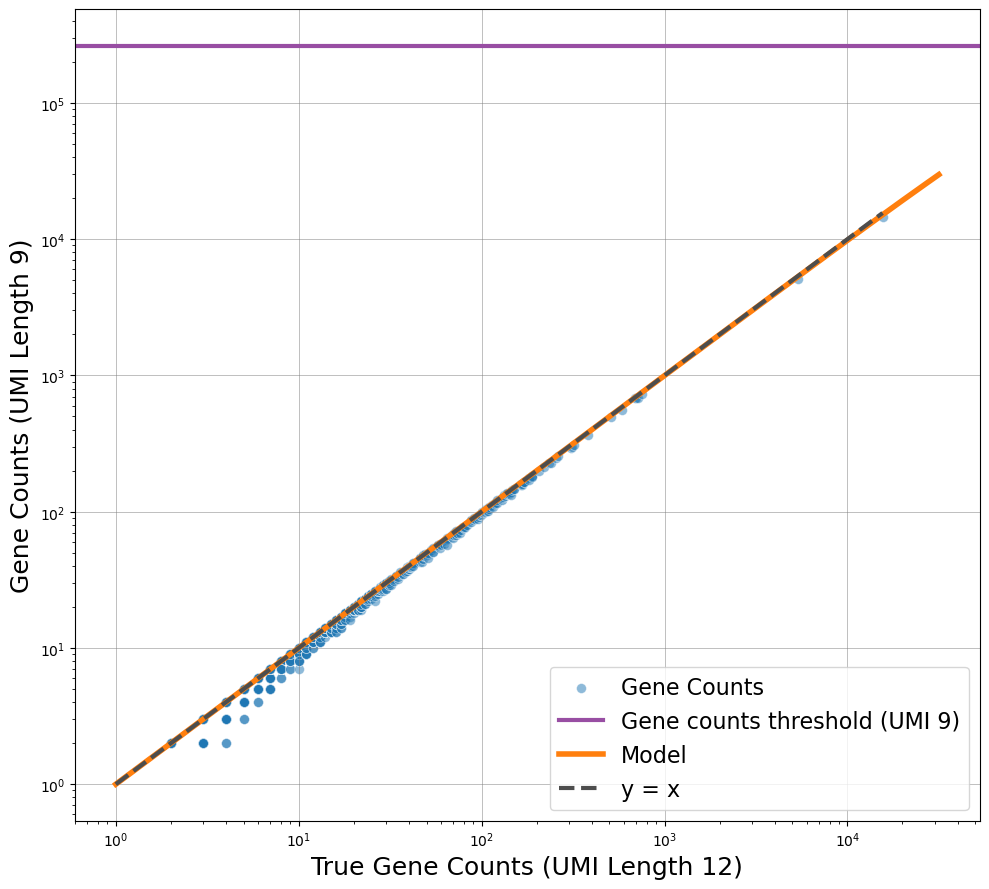

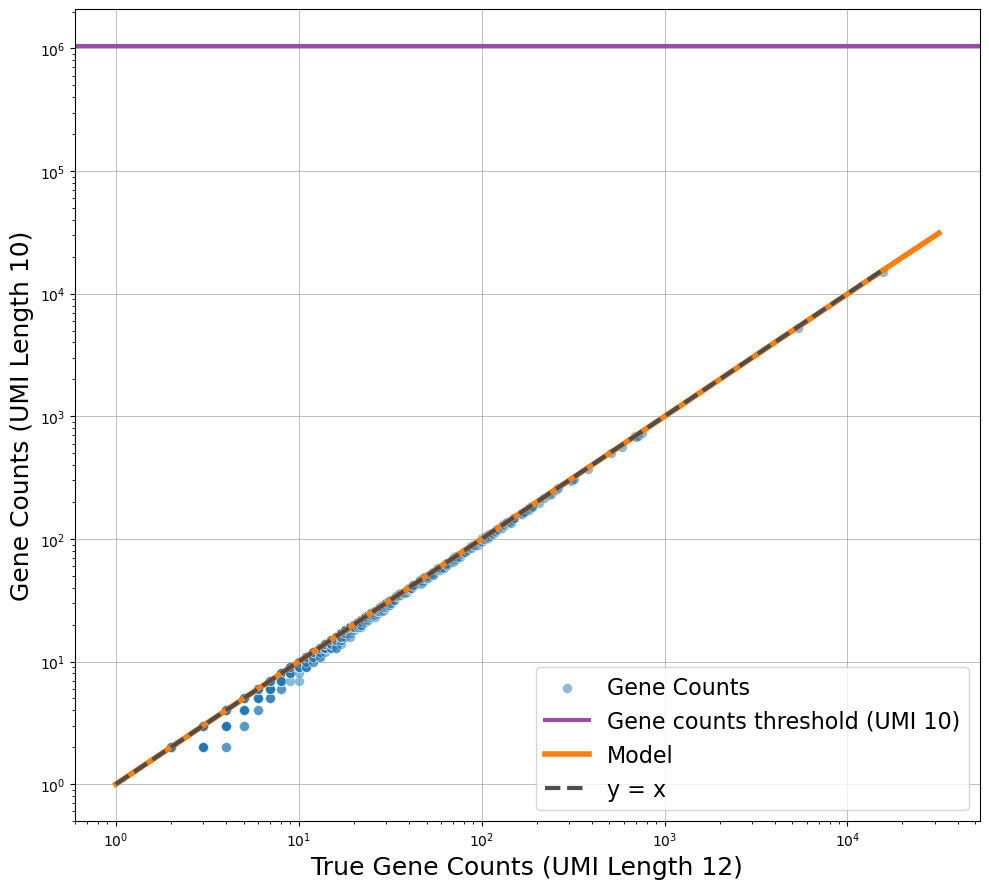

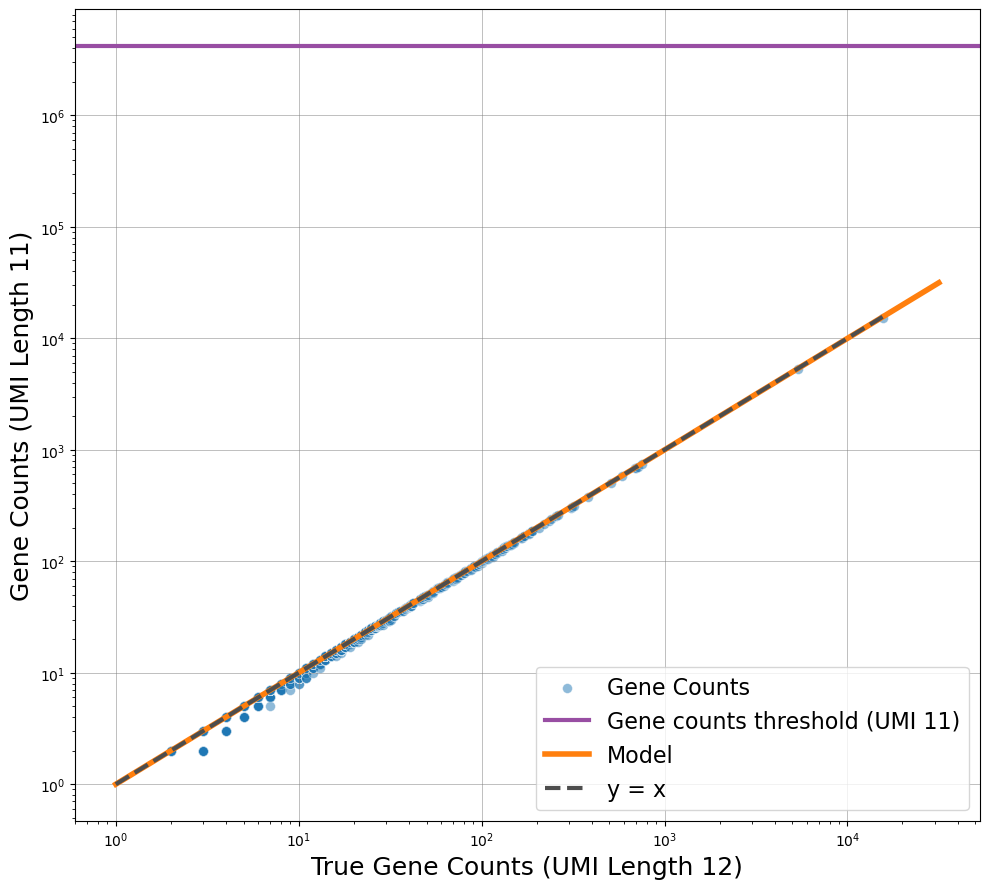

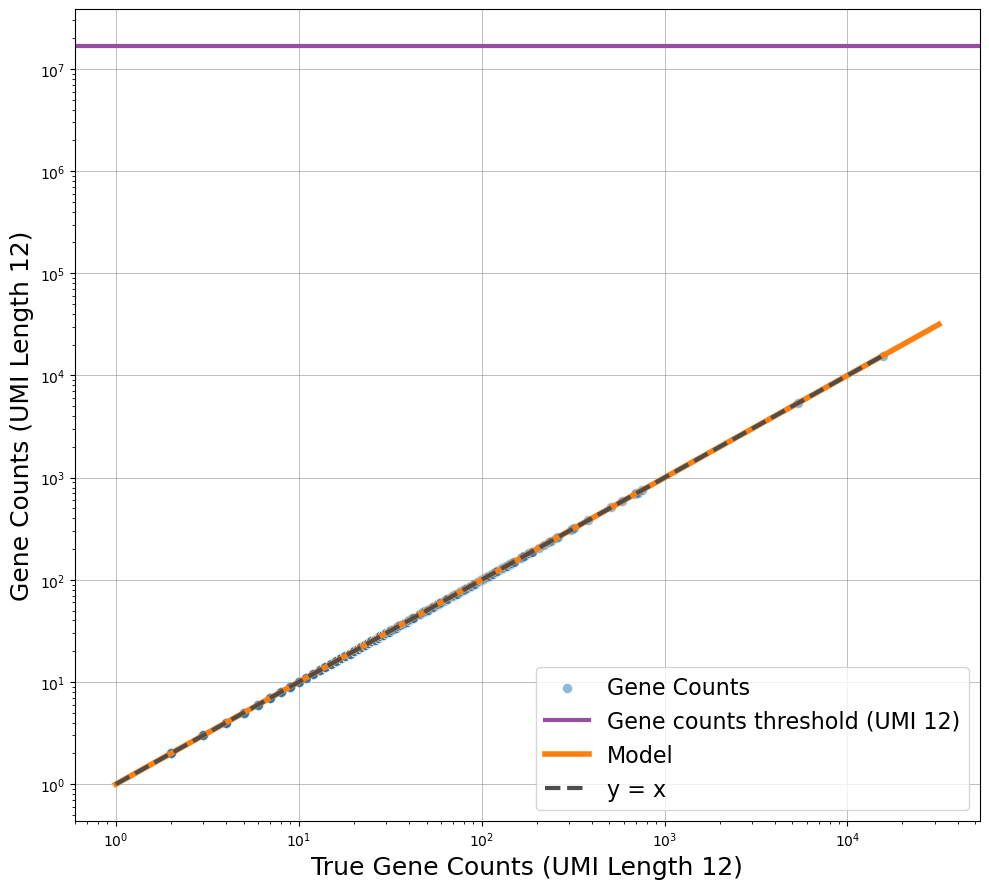

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
barcode = "CTACAGACAACAAAGT-1"
n_values = np.logspace(0, 4.5, 200)

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ub/counts_plots/naive"
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
os.makedirs(save_dir, exist_ok=True)

# Loop through j from 1 to 11
for j in range(1, 13):
        # Find the barcode index
        index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
        index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

        # Extract and process counts
        gene_counts_i = adata_dict[i].X[index_i].flatten()
        gene_counts_j = adata_dict[j].X[index_j].flatten()

        mask = gene_counts_i >= 1
        gene_counts_i = gene_counts_i[mask]
        gene_counts_j = gene_counts_j[mask]

        sorted_idx = np.argsort(gene_counts_i)
        sorted_gene_counts_i = gene_counts_i[sorted_idx] + 1
        sorted_gene_counts_j = gene_counts_j[sorted_idx] + 1

        # Create plot
        plt.figure(figsize=(10, 9))
        plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
                    c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
        
        y_asymptotic_value = 4**j
        plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')
        
        model_vals = f(n_values, j)
        plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')
        max_val = max(sorted_gene_counts1.max(), sorted_gene_counts1.max())
        plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
        plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
        plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
        plt.legend(fontsize=16)
        plt.tight_layout()

        # Save plot
        plt.savefig(f"{save_dir}/UMI_12_vs_{j}.pdf")
        plt.show()
        plt.close()


#### Inverting each adata[i] matrix to predict adata[12] and saving newly generated matrices

In [56]:
import numpy as np
import scanpy as sc
import anndata

def mom_estimator(y, K):
    # Convert input to a NumPy array (if not already)
    y = np.array(y)
    
    # Preallocate a result array of floats with the same shape as y.
    result = np.empty_like(y, dtype=float)
    
    # First, handle the special case: where y == K.
    special_mask = (y == K)
    if special_mask.any():
        # Compute the special value using the recursive formula.
        special_value = mom_estimator(K - 1, K) + K
        result[special_mask] = special_value
    
    # Then, compute the original (general) case only for entries where y != K.
    general_mask = ~special_mask
    if general_mask.any():
        denominator = np.log(1 - 1/K)
        result[general_mask] = np.log(1 - y[general_mask] / K) / denominator
    
    return result

for k in range(1, 13):
    
    # filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{k}.h5ad"
    # output_filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_{k}.h5ad"
    
    filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_{k}.h5ad"
    output_filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_{k}.h5ad"
    
    # filepath = f"/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/adata_{k}.h5ad"
    # output_filepath = f"/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/inverted2_adata_matrices/adata_inverted_{k}.h5ad"

    adata = sc.read_h5ad(filepath)
    original_matrix = adata.X.copy()  # If sparse, consider converting to dense with .toarray()

    K_val = 4 ** k
    predicted_gex = mom_estimator(original_matrix, K_val)

    new_adata = anndata.AnnData(X=predicted_gex, obs=adata.obs.copy(), var=adata.var.copy())
    new_adata.write_h5ad(output_filepath)

    print(f"New predicted gene expression matrix saved for UMI length {k} to: {output_filepath}")


New predicted gene expression matrix saved for UMI length 1 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_1.h5ad
New predicted gene expression matrix saved for UMI length 2 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_2.h5ad
New predicted gene expression matrix saved for UMI length 3 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_3.h5ad
New predicted gene expression matrix saved for UMI length 4 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_4.h5ad
New predicted gene expression matrix saved for UMI length 5 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/adata_inverted_5.h5ad
New predicted gene expression matrix saved for UMI length 6 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objec

#### Load the inverted adata matrices 

In [57]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/"  # Directory for 1k_PBMCs
directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/inverted2_adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_inverted_{i}.h5ad")
    
print(adata_dict[6])


# Load the ground truth vector 
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/adata_12.h5ad")
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
adata_12

AnnData object with n_obs × n_vars = 1232 × 28227


AnnData object with n_obs × n_vars = 1232 × 28227

### Saving Model Plots 

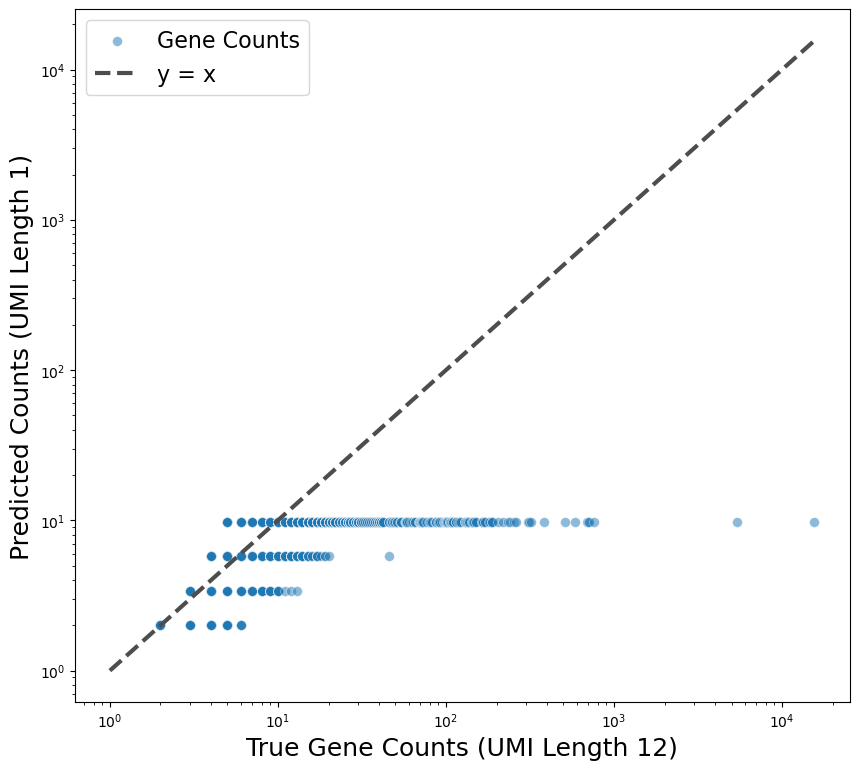

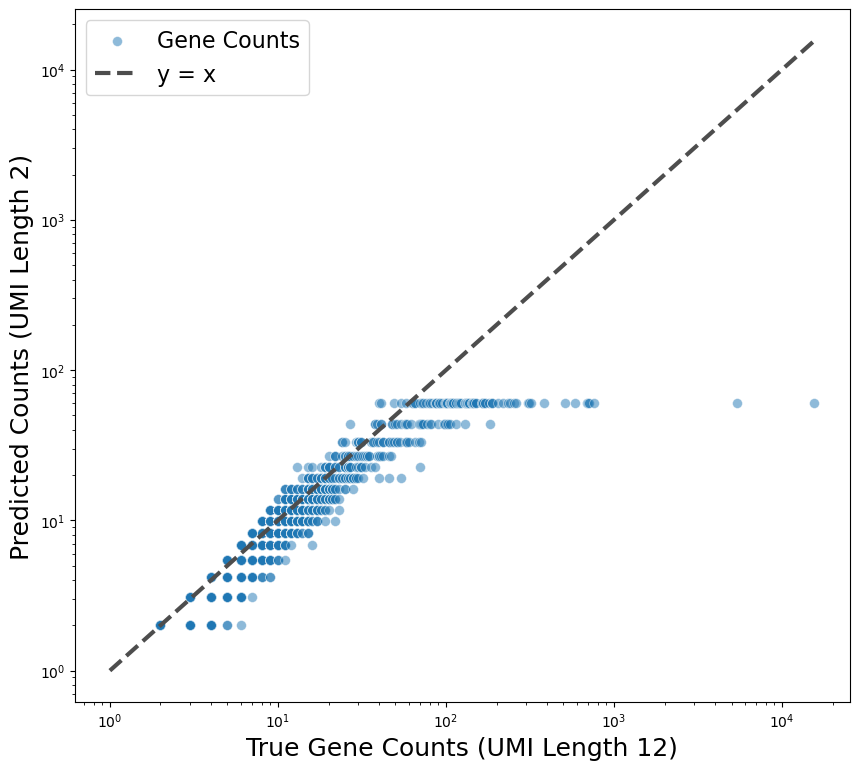

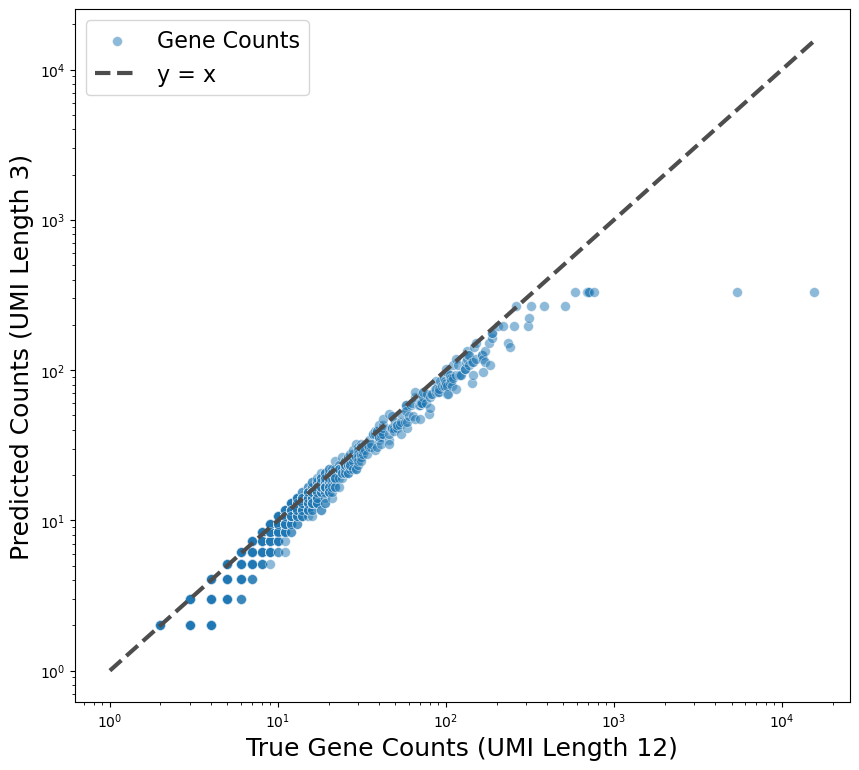

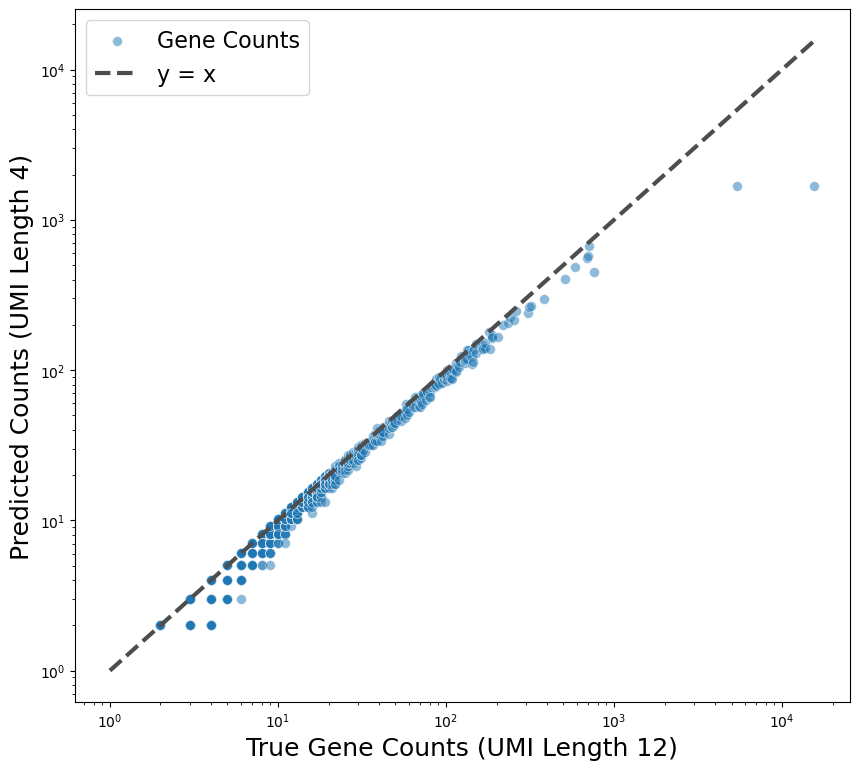

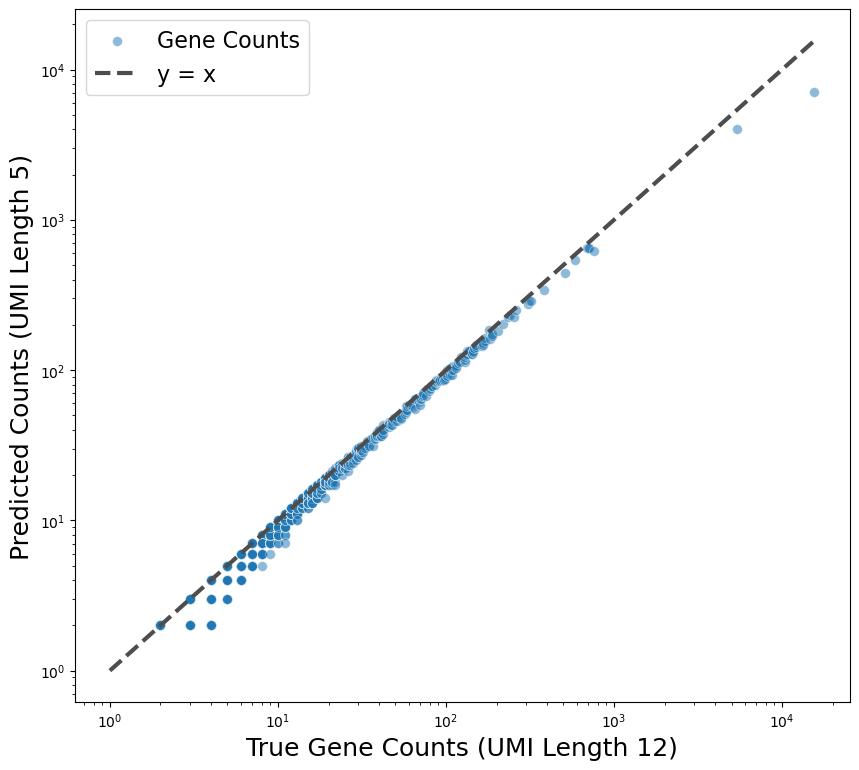

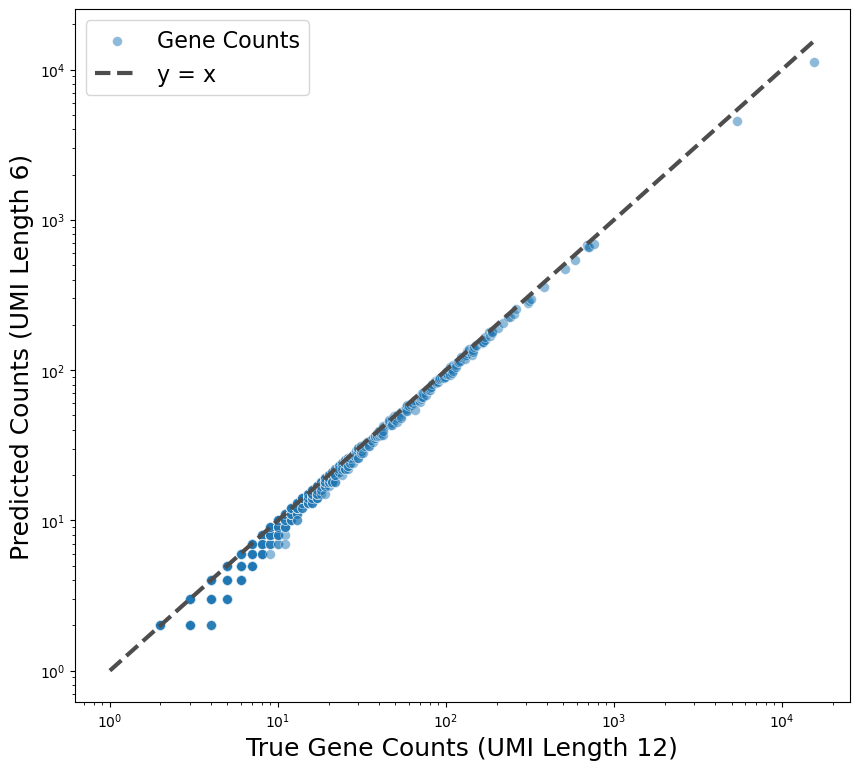

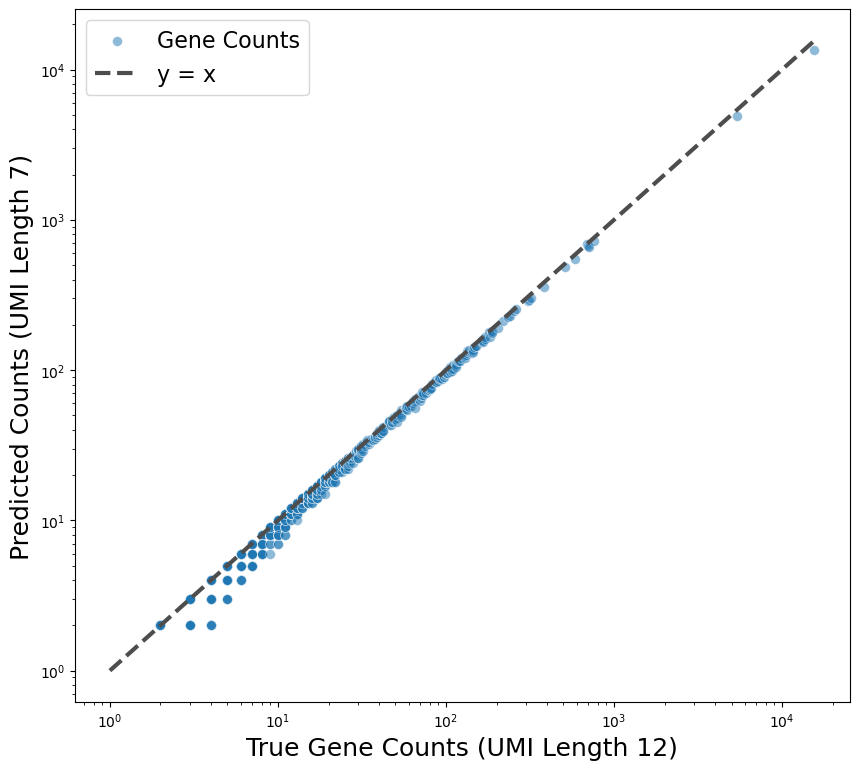

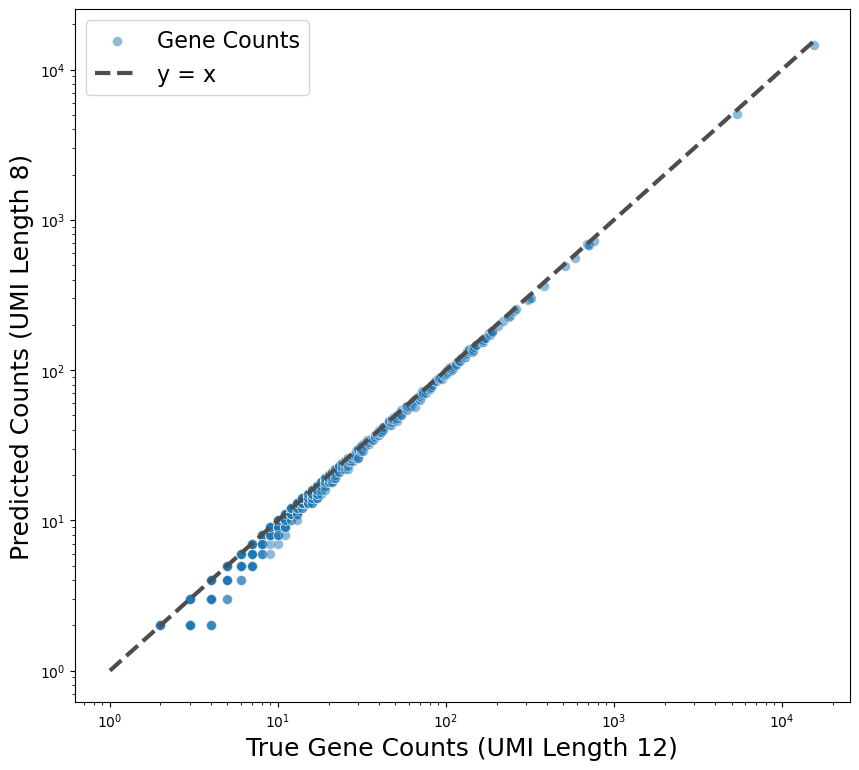

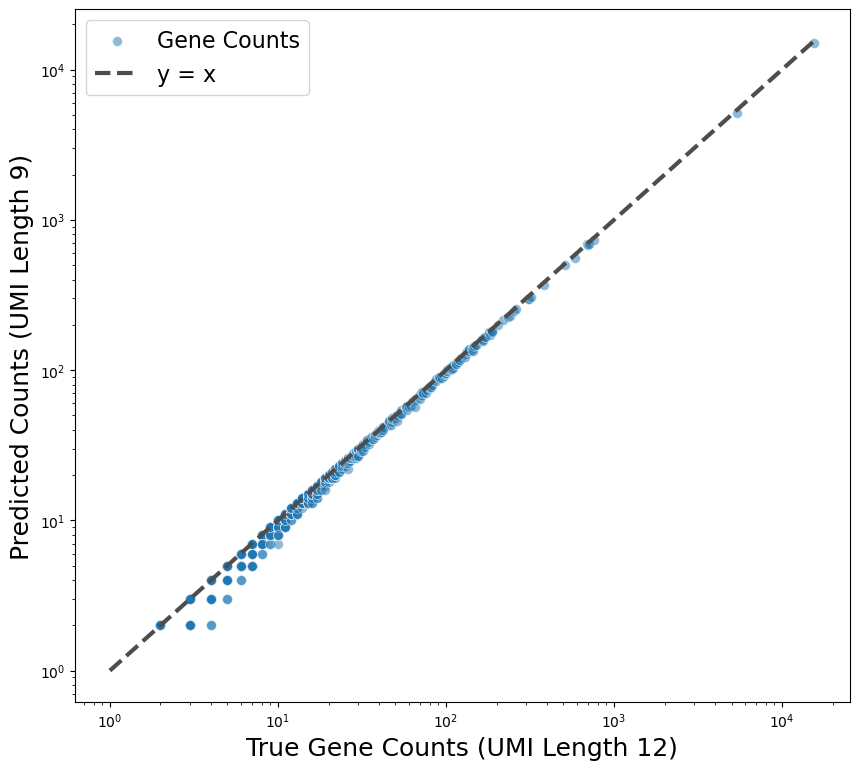

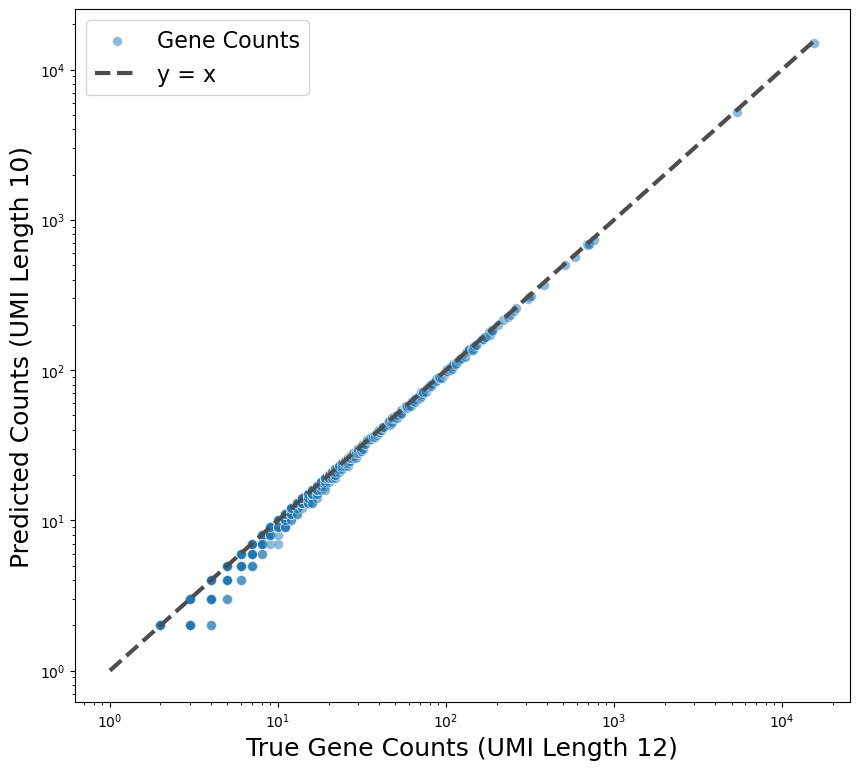

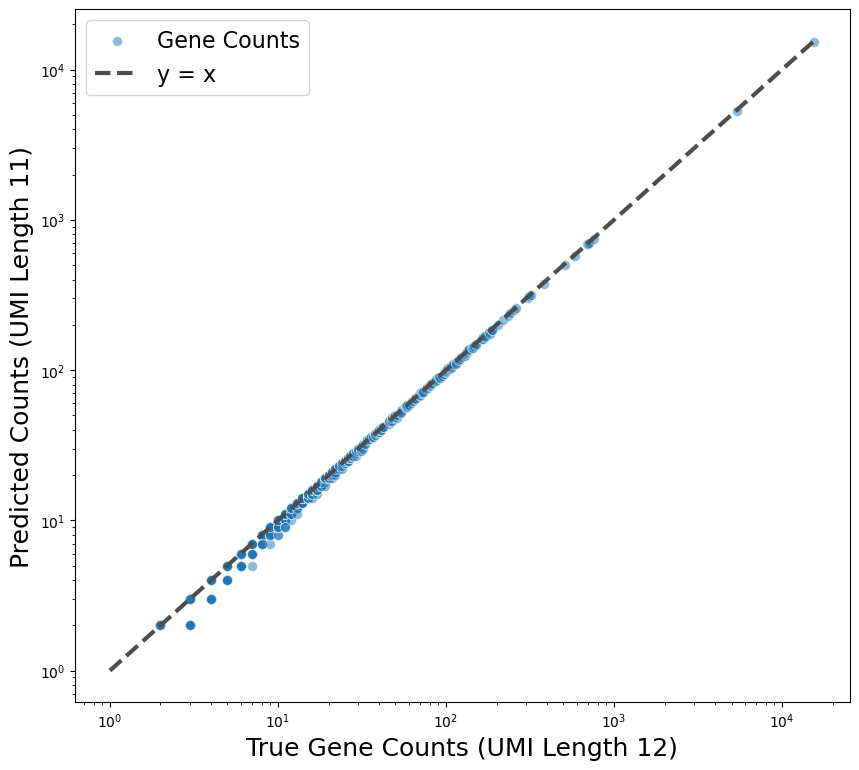

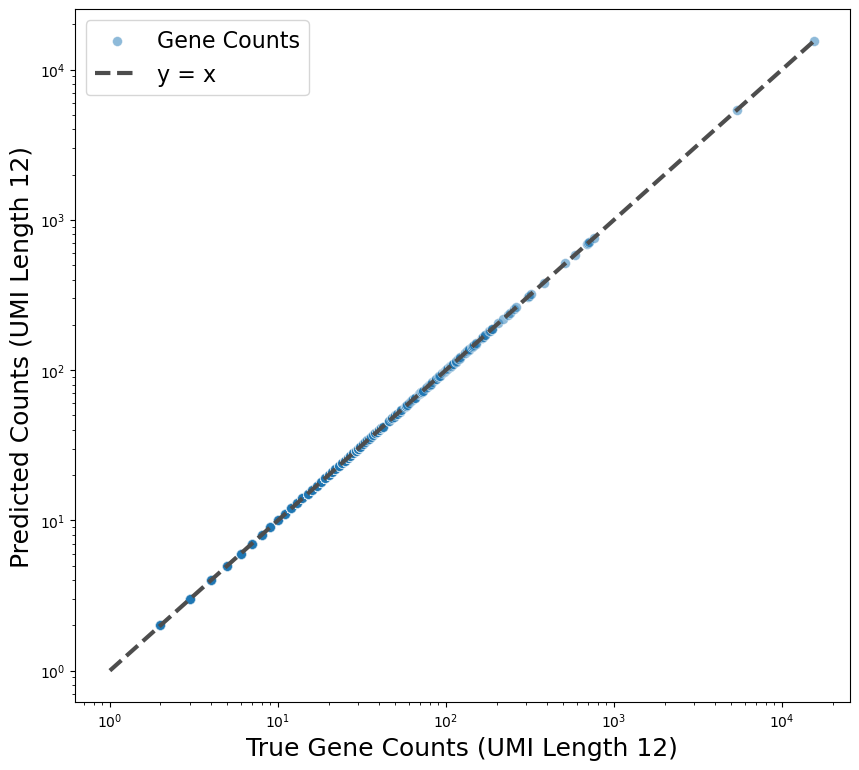

In [58]:
import numpy as np
import matplotlib.pyplot as plt

save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/model"

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    results = []
    for n in n_vals:
        result = 4**j * (1 - (1 - 1 / 4**j)**n)
        results.append(result) 
    return np.array(results)

# Define parameters
n_values = np.logspace(0, 4.5, 200)  # Example values for n (or x)
barcode = "CTACAGACAACAAAGT-1" # 1k dataset
# barcode = "CAGATTGCAGAGTGAC-1" # 10k dataset 


# Loop over j values from 1 to 12
for j in range(1,13):
    # Find the index of the barcode in each AnnData object
    index1 = np.where(adata_12.obs_names == barcode)[0][0]
    index2 = np.where(adata_dict[j].obs_names == barcode)[0][0]

    # Extract the gene counts for the barcode from both AnnData objects
    gene_counts1 = adata_12.X[index1].flatten()  # Gene counts for UMI length i (e.g., 12)
    gene_counts2 = adata_dict[j].X[index2].flatten()  # Gene counts for UMI length j

    # Create a boolean mask for gene_counts1 that are greater than or equal to 1
    mask = gene_counts1 >= 1 

    # Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
    gene_counts1 = gene_counts1[mask]
    gene_counts2 = gene_counts2[mask]

    # Sort the gene counts based on gene_counts1
    sorted_indices = np.argsort(gene_counts1)
    sorted_gene_counts1 = gene_counts1[sorted_indices]
    sorted_gene_counts2 = gene_counts2[sorted_indices]

    # Add 1 to both sorted_gene_counts1 and sorted_gene_counts2 to handle log scale properly
    sorted_gene_counts1 = sorted_gene_counts1 + 1
    sorted_gene_counts2 = sorted_gene_counts2 + 1

    # Create the scatter plot
    plt.figure(figsize=(10, 9))
    plt.scatter(sorted_gene_counts1, sorted_gene_counts2, alpha=0.5, c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

    # Adding the identity line
    max_val = max(sorted_gene_counts1.max(), sorted_gene_counts2.max())
    plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

    # Calculate function values for plotting
    f_n_4j = f(n_values, j)

    # Plot the y = 4^j asymptotic line
    # y_asymptotic_value = 4**j
    # plt.axhline(y=y_asymptotic_value, color='purple', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

    # Plot the function values as a line
    # plt.plot(n_values, f_n_4j, 'g-', linewidth=4, label="Model")

    # Log scale for both axes
    plt.xscale('log')
    plt.yscale('log')

    # Labels and legend
    plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
    plt.ylabel(f'Predicted Counts (UMI Length {j})', fontsize=18)
    # plt.title(f'Inverted Plot vs. Ground Truth (UMI {j})')
    plt.legend(fontsize=16)

    plt.savefig(f"{save_dir}/UMI_12_vs_{j}.pdf")
    # Show the plot
    plt.show()

## 3. MAE and MSE Calculations

### MAE and MSE for Model (1k dataset)

In [59]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # Ground truth UMI length (adata_12)
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model approach (UMI lengths 1-12)
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/"
model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_inverted_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (example adata_dict_model[6]):")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"
naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset (example adata_dict_naive[6]):")
print(adata_dict_naive[6])

# --- Compute Bulk MAE for the Model Approach ---
# Use ground truth counts from adata_12 and predicted counts from the model (inverted) dataset at UMI length j.
all_true_model = []
all_pred_model = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the model dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_model = adata_dict_model[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1
        pred_counts = gene_counts_model[mask] + 1
        
        all_true_model.extend(true_counts)
        all_pred_model.extend(pred_counts)

all_true_model = np.array(all_true_model)
all_pred_model = np.array(all_pred_model)
bulk_mae_model = calculate_mae(all_true_model, all_pred_model)
bulk_mse_model = calculate_mse(all_true_model, all_pred_model)
print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)


# --- Compute Bulk MAE for the Naive Approach ---
# Use ground truth counts from adata_12 and predicted counts from the naive dataset at UMI length j.
all_true_naive = []
all_naive_pred = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the naive dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_naive = adata_dict_naive[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1
        naive_counts = gene_counts_naive[mask] + 1
        
        all_true_naive.extend(true_counts)
        all_naive_pred.extend(naive_counts)

all_true_naive = np.array(all_true_naive)
all_naive_pred = np.array(all_naive_pred)
bulk_mae_naive = calculate_mae(all_true_naive, all_naive_pred)
bulk_mse_naive = calculate_mse(all_true_naive, all_naive_pred)
print("Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mae_naive)


print("Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mse_model)
print("Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mse_naive)


Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28227
Model Dataset (example adata_dict_model[6]):
AnnData object with n_obs × n_vars = 1232 × 28227
Naive Dataset (example adata_dict_naive[6]):
AnnData object with n_obs × n_vars = 1232 × 28227
Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5): 0.2054454353838581
Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5): 0.2697773071618592
Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5): 44.35100321178493
Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5): 193.53871096058873


### Compare MAE and MSE across Cells (1k)

In [60]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # UMI length for ground truth
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model MAE and MSE (UMI lengths 1-12)
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/"
model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_inverted_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (inverted), example adata_dict_model[6]:")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"
naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset, example adata_dict_naive[6]:")
print(adata_dict_naive[6])

# --- Compute Per-cell MAE for the Model Approach ---
mae_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mae_model_vector.append(calculate_mae(true_counts, predicted_counts))
mae_model_vector = np.array(mae_model_vector)
print("Per-cell Model MAE Vector:")
print(mae_model_vector)

# --- Compute Per-cell MSE for the Model Approach ---
mse_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mse_model_vector.append(calculate_mse(true_counts, predicted_counts))
mse_model_vector = np.array(mse_model_vector)
print("Per-cell Model MSE Vector:")
print(mse_model_vector)

# --- Compute Per-cell MAE for the Naive Approach ---
naive_mae_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mae_vector.append(calculate_mae(true_counts, naive_counts))
naive_mae_vector = np.array(naive_mae_vector)
print("Per-cell Naive MAE Vector:")
print(naive_mae_vector)

# --- Compute Per-cell MSE for the Naive Approach ---
naive_mse_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mse_vector.append(calculate_mse(true_counts, naive_counts))
naive_mse_vector = np.array(naive_mse_vector)
print("Per-cell Naive MSE Vector:")
print(naive_mse_vector)

Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28227
Model Dataset (inverted), example adata_dict_model[6]:
AnnData object with n_obs × n_vars = 1232 × 28227
Naive Dataset, example adata_dict_naive[6]:
AnnData object with n_obs × n_vars = 1232 × 28227
Per-cell Model MAE Vector:
[0.19673448 0.16378159 0.16216579 ... 0.15343375 0.16428822 0.14403862]
Per-cell Model MSE Vector:
[0.87274095 0.52585383 0.76272493 ... 1.298555   0.5039787  0.37107207]
Per-cell Naive MAE Vector:
[0.22857143 0.18307826 0.17902996 ... 0.17912553 0.20335525 0.15905849]
Per-cell Naive MSE Vector:
[2.03956044 1.19607277 2.04850214 ... 3.36812412 1.58127409 0.65121255]


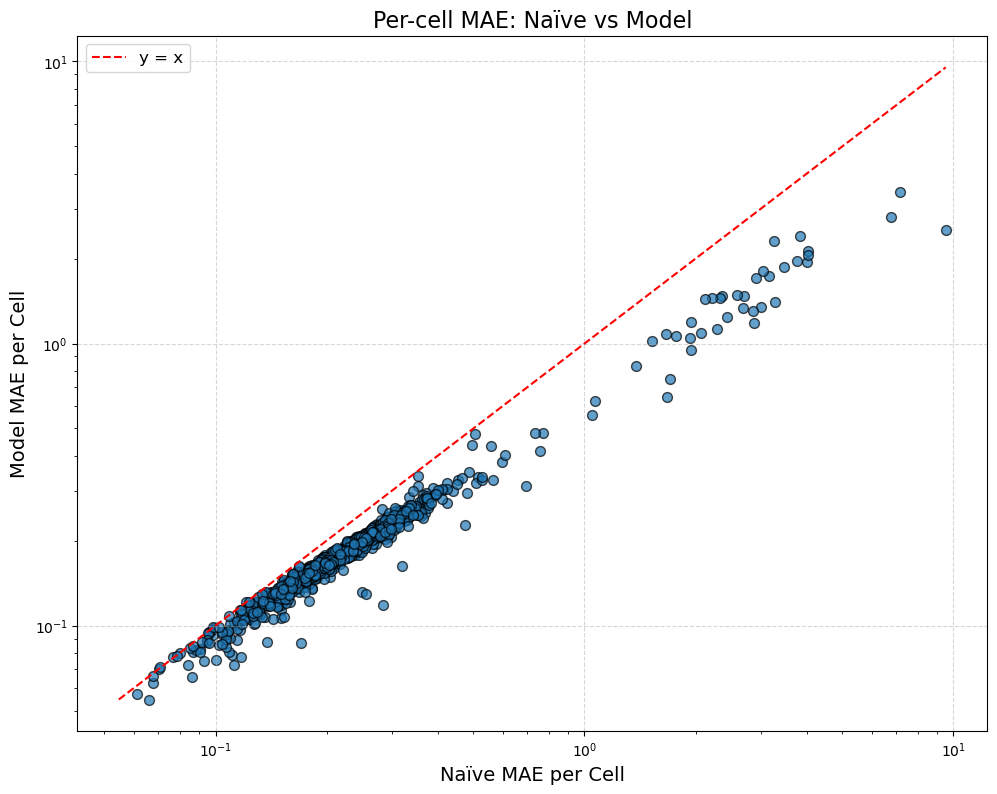

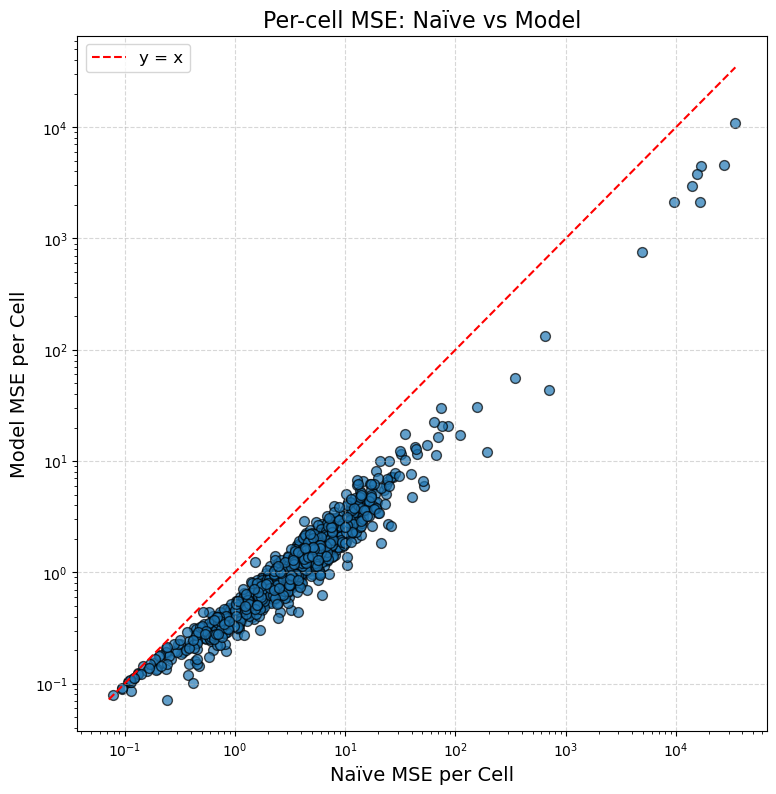

In [61]:

import matplotlib.pyplot as plt

# --- MAE Plot ---
plt.figure(figsize=(10, 8))
plt.scatter(naive_mae_vector, mae_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MAE per Cell", fontsize=14)
plt.ylabel("Model MAE per Cell", fontsize=14)
plt.title("Per-cell MAE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mae_vector.min(), mae_model_vector.min())
max_val = max(naive_mae_vector.max(), mae_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MAE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ub/mae_mse_plots/1k_per_cell_mae_naive_vs_model.pdf")
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mae_naive_vs_model.pdf")
plt.show()

# --- MSE Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(naive_mse_vector, mse_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MSE per Cell", fontsize=14)
plt.ylabel("Model MSE per Cell", fontsize=14)
plt.title("Per-cell MSE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mse_vector.min(), mse_model_vector.min())
max_val = max(naive_mse_vector.max(), mse_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MSE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ub/mae_mse_plots/1k_per_cell_mse_naive_vs_model.pdf")
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mse_naive_vs_model.pdf")
plt.show()